# Análisis Exploratorio de Datos

## Importamos librerías necesarias

In [2]:
# para la API de Lastfm
# import api.auth as auth

import pandas as pd 
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

#Para mostrar mejor las columnas de los datasets
from IPython.display import display
pd.options.display.max_columns = None

from itertools import product

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from ydata_profiling import ProfileReport

import math
import re
import datetime as dt


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
plt.style.use('seaborn-v0_8')

In [4]:
random_state = 19091952

## Cargamos el dataset generado

In [5]:
# load spotify_data
df = pd.read_csv('output/dataset_spotify_lastfm.csv')
df = df.sort_values(['popularity', 'lastfm_listeners', 'lastfm_playcounts'], ascending=False)
df.sample(5, random_state=random_state)

id        title          artist  \
4289    4YCrejiod7RUjLJisHhiiA    Intrology      Snoop Dogg   
271938  70RecAVg5QudOXfJs64sM5  Planetarium  Justin Hurwitz   
273053  7HIfg6iQgXkVEUMHAAXW2d         チノカテ            ヨルシカ   
104941  6GwsUXCzEQZ7bnEvHcT6O5  In My Blood          Alesso   
7081    39KG4kom3enSx4GTThuDGt      Coaster          Khalid   

                     artist_id  \
4289    7hJcb9fa4alzcOq3EaNPoG   
271938  2snm3HmsnDUDxbIChdl2Oj   
273053  4UK2Lzi6fBfUi9rpDt6cik   
104941  4AVFqumd2ogHFlRbKIjp1t   
7081    6LuN9FCkKOj5PcnpouEgny   

                                                  album album_type  \
4289                          Tha Blue Carpet Treatment      album   
271938  La La Land (Original Motion Picture Soundtrack)      album   
273053                                               幻燈      album   
104941                                          Forever      album   
7081                                      American Teen      album   

        album_total_tracks  disc_number  track_number release_date  \
4289                    21            1             1   2006-01-01   
271938                  15            1             7   2016-12-09   
273053                  10            1             3   2023-04-05   
104941                  14            1            10   2015-05-26   
7081                    15            1             6   2017-04-27   

        duration_ms  explicit  danceability  energy  key  loudness  mode  \
4289         119106      True         0.701   0.742    4    -5.036     0   
271938       257279     False         0.248   0.142    7   -15.443     1   
273053       247666     False         0.699   0.406    1    -7.402     1   
104941       183000     False         0.507   0.794    9    -2.486     0   
7081         199120     False         0.441   0.219    8   -14.586     1   

        speechiness  acousticness  instrumentalness  liveness  valence  \
4289         0.3730        0.1220          0.000006     0.617   0.4210   
271938       0.0379        0.9200          0.733000     0.548   0.0439   
273053       0.0502        0.6140          0.000030     0.106   0.6640   
104941       0.0549        0.0715          0.000000     0.200   0.3400   
7081         0.0419        0.9350          0.000000     0.115   0.2440   

          tempo  time_signature  \
4289     92.005               4   
271938  128.841               4   
273053  169.990               4   
104941  125.975               4   
7081     94.021               4   

                                              preview_url  \
4289                                                  NaN   
271938                                                NaN   
273053                                                NaN   
104941                                                NaN   
7081    https://p.scdn.co/mp3-preview/f00698a3a94c7546...   

                                            artist_genres  artist_followers  \
4289    ['g funk', 'gangster rap', 'hip hop', 'pop rap...          12002073   
271938                       ['hollywood', 'movie tunes']            152674   
273053                                          ['j-pop']           2596277   
104941  ['dance pop', 'edm', 'pop', 'pop dance', 'prog...           3895092   
7081                                   ['pop', 'pop r&b']          16201501   

        lastfm_listeners  lastfm_playcounts  popularity  
4289              9993.0            27569.0          28  
271938          146240.0           841500.0          56  
273053            9253.0            54691.0          55  
104941           12157.0            50809.0          31  
7081            262508.0          2103574.0          64

## Vista previa

In [10]:
df = df[[
    'id', 
    'title', 'artist', 'artist_id', 'album', 'album_type',
    'album_total_tracks', 'disc_number', 'track_number', 'duration_ms',
    'release_date',
    'explicit', 
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'key', 'mode', 
    'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence', 'artist_genres', 'artist_followers', 'lastfm_listeners', 'lastfm_playcounts', 
    'preview_url', 'popularity']]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

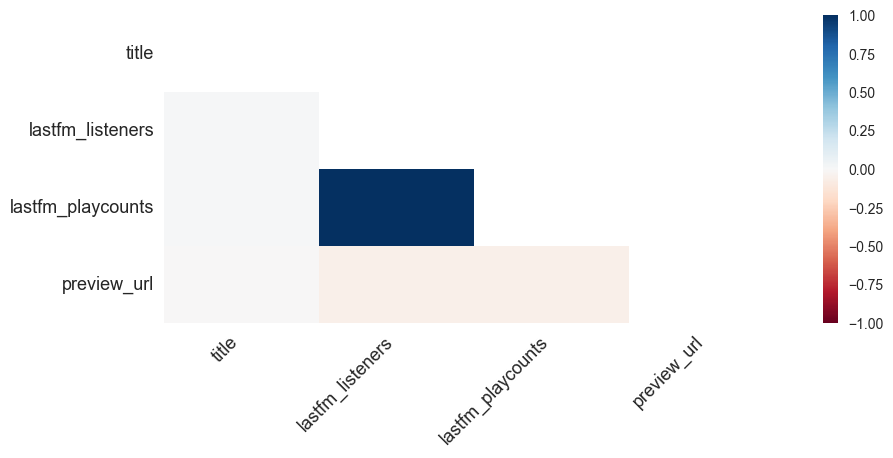

In [11]:
# Pandas Profiling del dataset
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_file("reports/preview.html")

### Distribución de variables numéricas previa a la limpieza

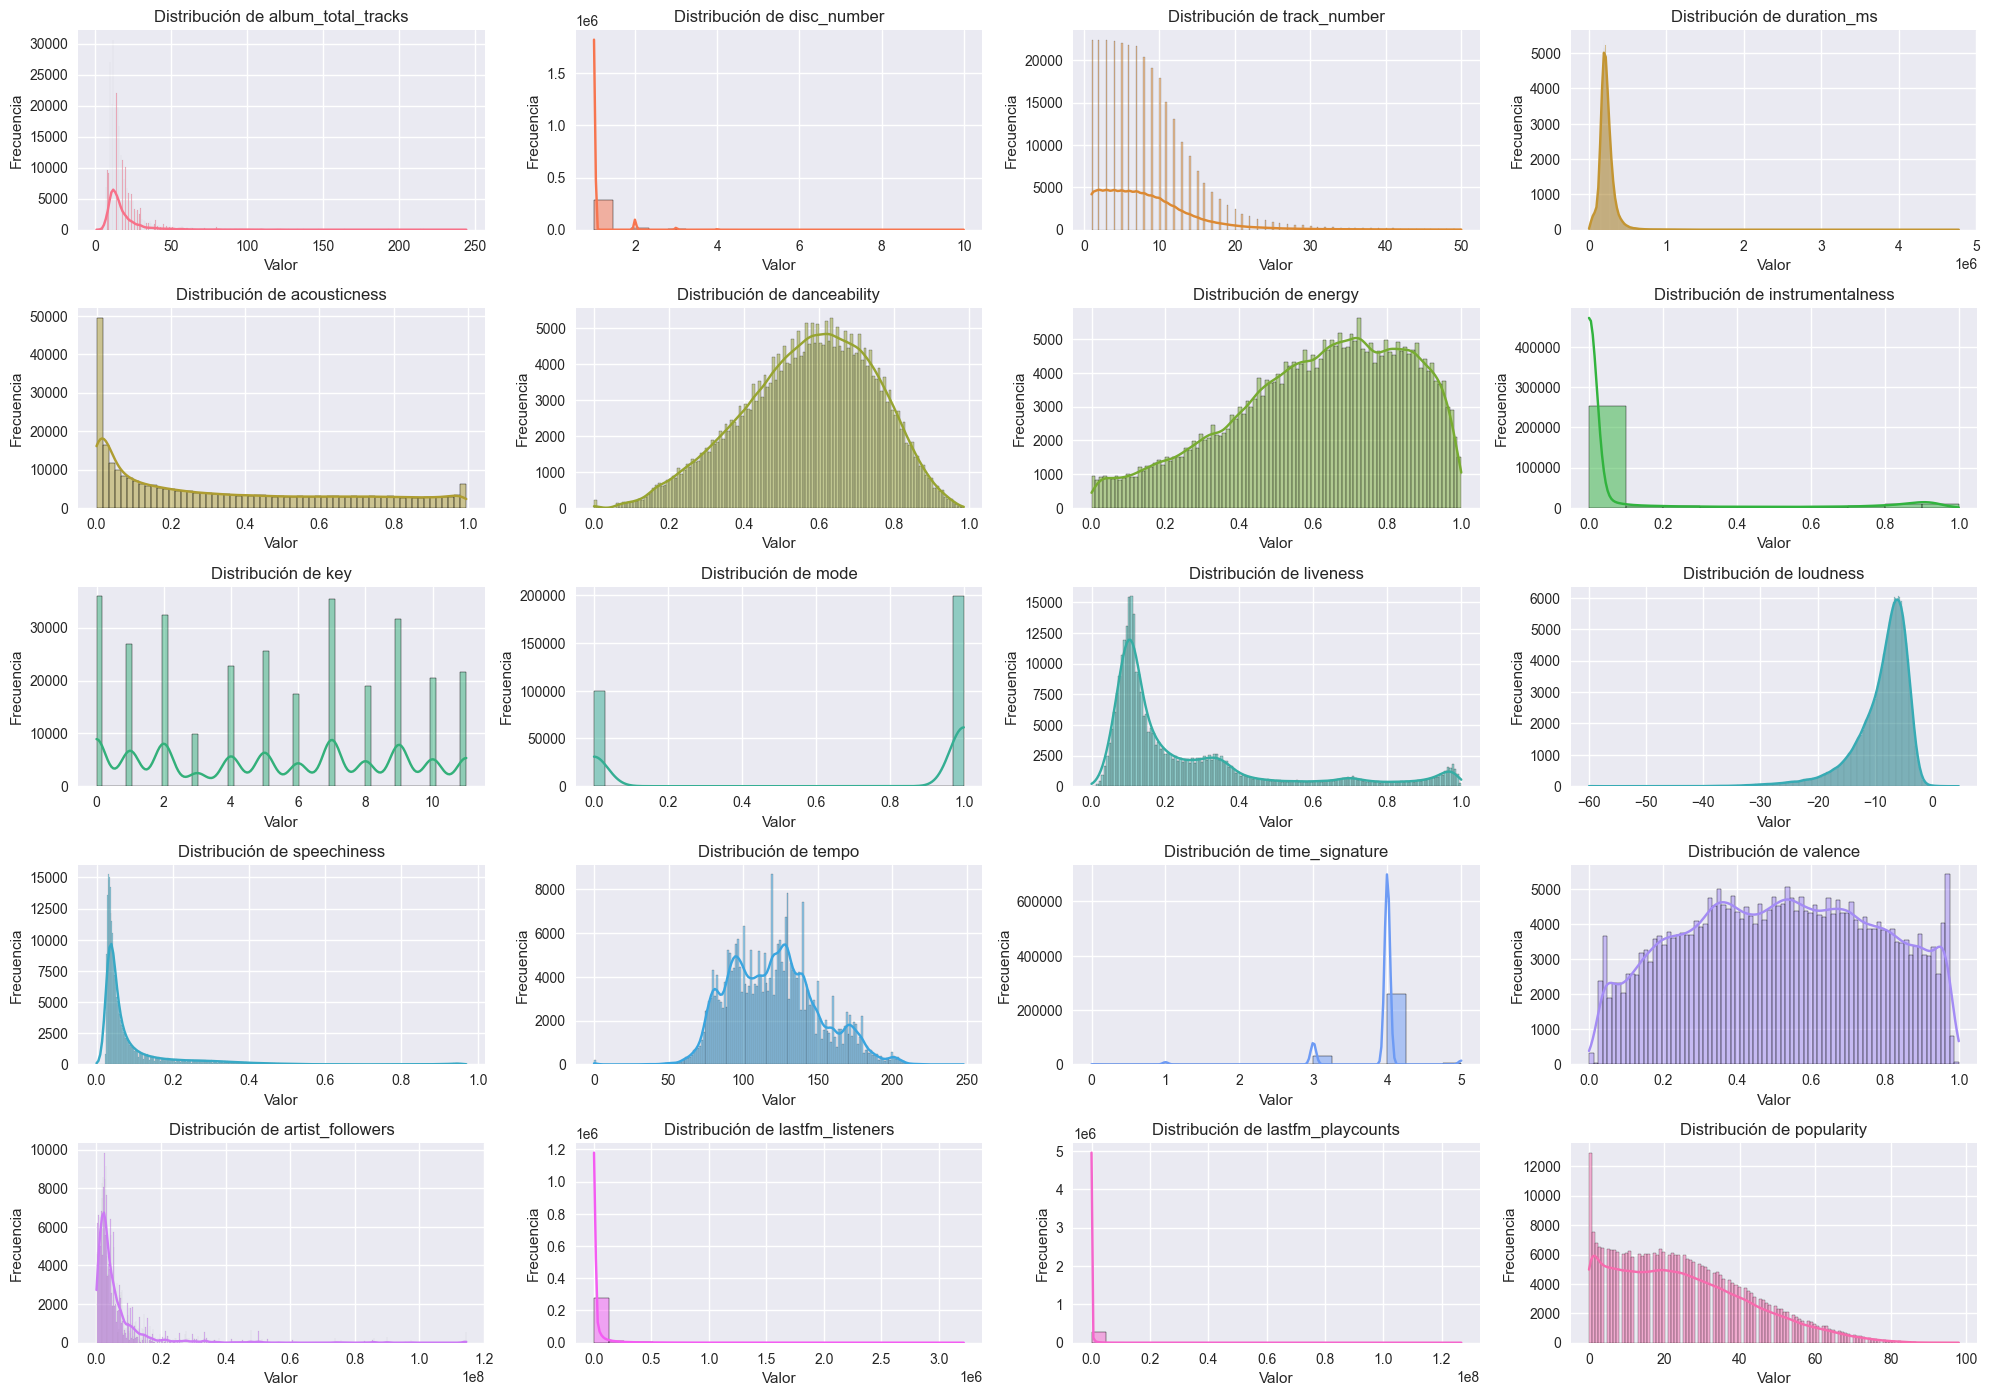

In [12]:
# Seleccionar las variables numéricas
num_vars = df.select_dtypes(include=['int64', 'float64']).columns

# Configurar el tamaño de la figura y la cuadrícula de subplots
n_cols = 4
n_rows = len(num_vars) // n_cols + (len(num_vars) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5 * 9/16))
axes = axes.flatten()

# Colores para los histogramas
colors = sns.color_palette("husl", len(num_vars))

# Crear un gráfico de distribución para cada variable numérica
for ax, var, color in zip(axes, num_vars, colors):
    if var == 'instrumentalness':
        sns.histplot(df[var], kde=True, ax=ax, color=color, bins=10)
    elif var == 'lastfm_playcounts' or var == 'lastfm_listeners':
        sns.histplot(df[var], kde=True, ax=ax, color=color, bins=25)
    else:
        sns.histplot(df[var], kde=True, ax=ax, color=color)
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')

# Eliminar subplots vacíos
for ax in axes[len(num_vars):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## Preprocesamiento de datos

### DUPLICADOS

#### `track_id`

In [6]:
# search for duplicate tracks

dupes_id= df[df['id'].duplicated()][['id', 'title', 'artist', 'album', 'popularity']]
print(f'Hay {len(dupes_id)} canciones duplicadas por track_id.')

dupes_id

Hay 24906 canciones duplicadas por track_id.


id                                  title  \
2403    2tudvzsrR56uom6smgOcSf                              Like That   
5389    3w0w2T288dec0mgeZZqoNN                               CARNIVAL   
5390    3w0w2T288dec0mgeZZqoNN                               CARNIVAL   
2399    28drn6tQo95MRvO0jQEo5C                              Type Shit   
6842    3GCdLUSnKSMJhs4Tj6CV3s               All The Stars (with SZA)   
...                        ...                                    ...   
255857  0Y74K5ij7jMthyG9chovhl                   How to Correct Nila?   
255865  6enlc51JPIfUQVOF3IYrnf              Vaa En Anjala (Version 2)   
260391  24lMNV5RY7uxgFFFPD2mXO  Y Se Parece A Ti - Remasterizado 2022   
260403  1ta9UFwb4a8kLpr6DY3YSi         El Espejo - Remasterizado 2022   
260407  043F2tCPAvmTAVqoo9nB4w      Las Guilotas - Remasterizado 2022   

                   artist                                              album  \
2403               Future                                 WE DON'T TRUST YOU   
5389                   ¥$                                         VULTURES 1   
5390                   ¥$                                         VULTURES 1   
2399               Future                                 WE DON'T TRUST YOU   
6842       Kendrick Lamar  Black Panther The Album Music From And Inspire...   
...                   ...                                                ...   
255857     Hiphop Tamizha        Meesaya Murukku (Original Background Score)   
255865     Hiphop Tamizha        Meesaya Murukku (Original Background Score)   
260391  Valentín Elizalde              Y Se Parece A Ti (Remasterizado 2022)   
260403  Valentín Elizalde              Y Se Parece A Ti (Remasterizado 2022)   
260407  Valentín Elizalde              Y Se Parece A Ti (Remasterizado 2022)   

        popularity  
2403            91  
5389            87  
5390            87  
2399            87  
6842            86  
...            ...  
255857           0  
255865           0  
260391           0  
260403           0  
260407           0  

[24906 rows x 5 columns]

In [7]:
print(f'El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataset tiene 299082 filas y 30 columnas.


Eliminamos los duplicados quedándonos con el primero con más popularidad, aunque deberían tener la misma.

Existe la posibilidad de que haya filas duplicadas con distinta popularidad, si se han extraído en fechas distintas (24-48h de margen) 

In [8]:
# Eliminar duplicados manteniendo la ocurrencia de mayor popularidad
df = df.sort_values(['popularity', 'lastfm_listeners', 'lastfm_playcounts'], ascending=False)
df = df.drop_duplicates(subset='id')
print(f'El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataset tiene 274176 filas y 30 columnas.


#### `title` y `artist_id`

Hacemos lo mismo para las duplicadas por título y artista en distintos álbumes, obteniendo la de mayor popularidad

In [9]:
# search for duplicate tracks by name and artist
dupes_name_artist = df[df.duplicated(subset=['title', 'artist'], keep=False)]
print(f'Hay {len(dupes_name_artist)} canciones duplicadas por nombre y artista.')

dupes_name_artist.sample(5, random_state=random_state)

Hay 135 canciones duplicadas por nombre y artista.


id  \
177769  4wAkqbqhfTMShtMQVagFle   
177771  76aBxdFnKXmPSCWnBNBAQ8   
281875  3bo5onvqyCg1FjVGwzrDUY   
232874  2liDiVSzNWq6Iv9PKkTmlZ   
232890  78ctkR9u8M5SvIEo07GrIY   

                                                    title          artist  \
177769                   Looks That Kill (2021- Remaster)     Mötley Crüe   
177771  God Bless the Children of the Beast (2021- Rem...     Mötley Crüe   
281875                             Los Grifos De La Santa  La Santa Grifa   
232874  The Village Green Preservation Society (2018 S...       The Kinks   
232890     Do You Remember Walter? (2018 Stereo Remaster)       The Kinks   

                     artist_id  \
177769  0cc6vw3VN8YlIcvr1v7tBL   
177771  0cc6vw3VN8YlIcvr1v7tBL   
281875  1oH2B8tcHn4Gpl2bmmyd4A   
232874  1SQRv42e4PjEYfPhS0Tk9E   
232890  1SQRv42e4PjEYfPhS0Tk9E   

                                                    album album_type  \
177769              Shout At The Devil (40th Anniversary)      album   
177771              Shout At The Devil (40th Anniversary)      album   
281875                              Hits Visuales, Vol. 3      album   
232874  The Kinks Are the Village Green Preservation S...      album   
232890  The Kinks Are the Village Green Preservation S...      album   

        album_total_tracks  disc_number  track_number release_date  \
177769                  16            1             3   2023-10-27   
177771                  16            1             5   2023-10-27   
281875                  12            1             1   2019-08-02   
232874                  15            1             1   1968-11-22   
232890                  60            1             2   1968-01-01   

        duration_ms  explicit  danceability  energy  key  loudness  mode  \
177769       247891     False         0.483   0.957    0    -4.491     1   
177771        90306     False         0.499   0.349    9   -12.933     0   
281875       266755      True         0.731   0.781    1    -3.261     1   
232874       171693     False         0.557   0.948    7    -7.168     1   
232890       149533     False         0.462   0.692    0    -8.583     1   

        speechiness  acousticness  instrumentalness  liveness  valence  \
177769       0.0417       0.00381           0.00563    0.1160    0.719   
177771       0.0306       0.70400           0.93400    0.3070    0.315   
281875       0.3250       0.01700           0.00000    0.0978    0.728   
232874       0.0597       0.23400           0.00000    0.0658    0.642   
232890       0.0525       0.09990           0.00000    0.0740    0.543   

          tempo  time_signature  \
177769  135.938               4   
177771  117.445               4   
281875   83.837               4   
232874   97.425               4   
232890  183.548               4   

                                              preview_url  \
177769  https://p.scdn.co/mp3-preview/6cbe94a965e8c339...   
177771  https://p.scdn.co/mp3-preview/dd1ffb3e34c82f04...   
281875  https://p.scdn.co/mp3-preview/86425df0a28f4108...   
232874  https://p.scdn.co/mp3-preview/470ed4eb2bd62711...   
232890  https://p.scdn.co/mp3-preview/d5789fd394c988e3...   

                                            artist_genres  artist_followers  \
177769  ['album rock', 'alternative metal', 'glam meta...           5175991   
177771  ['album rock', 'alternative metal', 'glam meta...           5175991   
281875  ['mexican hip hop', 'sad sierreno', 'tamaulipa...           5771729   
232874  ['album rock', 'art rock', 'british invasion',...           2585145   
232890  ['album rock', 'art rock', 'british invasion',...           2585145   

        lastfm_listeners  lastfm_playcounts  popularity  
177769            3334.0            10664.0          30  
177771            1548.0             3249.0          24  
281875             292.0             1568.0          19  
232874           10620.0            30539.0          22  
232890            7413.0            19995.0          30

In [10]:
#search for title kickstart my heart by artist_id 0cc6vw3VN8YlIcvr1v7tBL
df[(df['artist_id'] == '0cc6vw3VN8YlIcvr1v7tBL') & (df['title'] == 'Kickstart My Heart')]

id               title       artist  \
177932  65HA9FsYyA2xro9RzNlNmy  Kickstart My Heart  Mötley Crüe   
177847  4mozZaRpA4q16QHWmUftS1  Kickstart My Heart  Mötley Crüe   

                     artist_id                          album album_type  \
177932  0cc6vw3VN8YlIcvr1v7tBL  Dr. Feelgood (Deluxe Version)      album   
177847  0cc6vw3VN8YlIcvr1v7tBL         Carnival Of Sins: Live      album   

        album_total_tracks  disc_number  track_number release_date  \
177932                  16            1             5   1989-09-01   
177847                  23            1            21   2006-02-07   

        duration_ms  explicit  danceability  energy  key  loudness  mode  \
177932       282653     False         0.363   0.982    7    -3.621     0   
177847       425733      True         0.159   0.977    5    -4.358     1   

        speechiness  acousticness  instrumentalness  liveness  valence  \
177932        0.300      0.001230           0.00218     0.284    0.275   
177847        0.136      0.000007           0.79700     0.960    0.209   

          tempo  time_signature  \
177932  179.230               4   
177847   89.721               4   

                                              preview_url  \
177932  https://p.scdn.co/mp3-preview/caae765db6625225...   
177847  https://p.scdn.co/mp3-preview/b1db08edbabcbb55...   

                                            artist_genres  artist_followers  \
177932  ['album rock', 'alternative metal', 'glam meta...           5175991   
177847  ['album rock', 'alternative metal', 'glam meta...           5175991   

        lastfm_listeners  lastfm_playcounts  popularity  
177932          701428.0          5691381.0          77  
177847          701428.0          5691381.0          25

In [11]:
print(f'El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataset tiene 274176 filas y 30 columnas.


In [12]:
# Eliminar duplicados manteniendo la ocurrencia de mayor popularidad
df = df.sort_values(['popularity', 'lastfm_listeners', 'lastfm_playcounts'], ascending=False)
df = df.drop_duplicates(subset=['title', 'artist_id'])

In [13]:
print(f'El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataset tiene 274097 filas y 30 columnas.


In [14]:
# search for duplicate tracks by name and artist and album
dupes = df[df.duplicated(keep=False)][['title', 'artist','artist_id', 'album', 'popularity']]
print(f'Hay {len(dupes)} canciones duplicadas por nombre y artista y album.')

dupes

Hay 0 canciones duplicadas por nombre y artista y album.


Empty DataFrame
Columns: [title, artist, artist_id, album, popularity]
Index: []

### NULOS

In [15]:
nulos = pd.DataFrame(df.isnull().sum())
nulos = nulos.rename(columns={0: 'total'})
nulos[nulos['total'] > 0]

total
title                  1
preview_url        81129
lastfm_listeners    3973
lastfm_playcounts   3973

Encontramos un caso de una canción sin `title`, pero con todas las características musicales. No debería ser un problema, ya que eliminaremos esa columna para el aprendizaje de modelos

In [16]:
# buscamos el ID de la canción que tiene el campo 'title' nulo
missing_song = df[df['title'].isnull()]
missing_song

id title             artist  \
219916  7BGQCe62A58Q5ZgpQFX93t   NaN  Elevation Worship   

                     artist_id             album album_type  \
219916  3YCKuqpv9nCsIhJ2v8SMix  There Is a Cloud      album   

        album_total_tracks  disc_number  track_number release_date  \
219916                  17            1            10   2017-03-17   

        duration_ms  explicit  danceability  energy  key  loudness  mode  \
219916       350026     False         0.287   0.446    5    -7.214     1   

        speechiness  acousticness  instrumentalness  liveness  valence  \
219916       0.0317         0.019               0.0       0.1   0.0387   

          tempo  time_signature  \
219916  138.727               4   

                                              preview_url  \
219916  https://p.scdn.co/mp3-preview/7303c77d961cbeb5...   

                                artist_genres  artist_followers  \
219916  ['ccm', 'christian music', 'worship']           3448788   

        lastfm_listeners  lastfm_playcounts  popularity  
219916               NaN                NaN          31

Como se guardó como canción sin título, la llamada posterior a last.fm devolvió error.

Si buscamos la canción en Spotify, vemos que se llama "None".

<iframe style="border-radius:12px" src="https://open.spotify.com/embed/track/7BGQCe62A58Q5ZgpQFX93t?utm_source=generator" width="100%" height="152" frameBorder="0" allowfullscreen="" allow="autoplay; clipboard-write; encrypted-media; fullscreen; picture-in-picture" loading="lazy"></iframe>

In [17]:
# # connect to lastfm API using api/auth.py script to get the network object and retrieve the lastfm_playcounts and lastfm_listeners for the song
# import api.auth as auth

# network = auth.get_lastfm()
# song = network.get_track('None', 'Elevation Worship')
# listeners = song.get_listener_count()
# playcounts = song.get_playcount()
# print(f'Listeners: {listeners}, Playcount: {playcounts}')

La API de Last.fm no es capaz de buscar la canción. Rellenamos los valores a mano.

In [18]:
# renombrar la fila con id 7BGQCe62A58Q5ZgpQFX93t a title 'None', lastfm_listeners 1642 y lastfm_playcounts 11152
df.loc[df['id'] == '7BGQCe62A58Q5ZgpQFX93t', 'title'] = 'None'
df.loc[df['id'] == '7BGQCe62A58Q5ZgpQFX93t', 'lastfm_listeners'] = 1642
df.loc[df['id'] == '7BGQCe62A58Q5ZgpQFX93t', 'lastfm_playcounts'] = 11152

También vemos varios casos de `preview_url` nulo.
Esta variable contiene un enlace con una muestra de 30 segundos de la canción, por lo que no será de utilidad

Parece que no se han encontrado 3605 canciones en `last.fm` usando el nombre del artista y de la canción.
Para el estudio del dataset de Spotify + last.fm, eliminaremos las filas sin datos sociales del AudioScrobbler por ser una cantidad minúscula.

In [19]:
# delete rows without lastfm data

df = df.dropna(subset=['lastfm_listeners'])
df = df.dropna(subset=['lastfm_playcounts'])

### Eliminar pistas que no son canciones

#### `duration_ms < 90 segundos` (interludios)

In [20]:
# delete rows with duration_ms < 90 seconds
print(f'Número de canciones con duración menor a 90 segundos: {len(df[df["duration_ms"] <= 90000])}')

Número de canciones con duración menor a 90 segundos: 9328


In [21]:
df = df[df['duration_ms'] > 90000]

#### `duration_ms > 10 minutos`

In [22]:
# delete rows with duration_ms > 10 minutes
print(f'Número de canciones con duración mayor a 10 minutos: {len(df[df["duration_ms"] >= 600000])}')


Número de canciones con duración mayor a 10 minutos: 2417


In [23]:
df = df[df['duration_ms'] < 600000]

#### `speechiness > 0.66` (entrevistas, charlas, reportajes)

In [24]:
# delete rows with speechiness > 0.66
print(f'Número de canciones con speechiness mayor a 0.66: {len(df[df["speechiness"] > 0.66])}')

Número de canciones con speechiness mayor a 0.66: 1317


In [25]:
df[df["speechiness"] > 0.66].head()

id                       title  \
82060   5uZm7EFtP5aoTJvx5gv9Xf                      Jungle   
138319  6dr7ekfhlbquvsVY8D7gyk             Aaron Burr, Sir   
264523  2BF6mQdYAkLmeRQmX7YyPy           Me Desculpa Jay Z   
254113  5lw8Mgb4LyhriPIC86gV6e  RNP (feat. Anderson .Paak)   
223794  4n7c4QoSavoKz7qLitbQbD                 Green Light   

                        artist               artist_id  \
82060   A Boogie Wit da Hoodie  31W5EY0aAly4Qieq6OFu6I   
138319      Lin-Manuel Miranda  4aXXDj9aZnlshx7mzj3W1N   
264523       Baco Exu do Blues  78nr1pVnDR7qZH6QbVMYZf   
254113                  Cordae  0huGjMyP507tBCARyzSkrv   
223794                Rod Wave  45TgXXqMDdF8BkjA83OM7z   

                                              album album_type  \
82060                                        Artist      album   
138319  Hamilton (Original Broadway Cast Recording)      album   
264523                                     Bluesman      album   
254113                                 The Lost Boy      album   
223794                                Ghetto Gospel      album   

        album_total_tracks  disc_number  track_number release_date  \
82060                   11            1             6   2016-09-16   
138319                  46            1             2   2015-09-25   
264523                   9            1             3   2018-11-23   
254113                  15            1             6   2019-07-26   
223794                  14            1             4   2019-11-01   

        duration_ms  explicit  danceability  energy  key  loudness  mode  \
82060        174192      True         0.538   0.520    7   -11.063     0   
138319       156630     False         0.646   0.439    7   -10.837     1   
264523       212436     False         0.375   0.716    0    -7.510     1   
254113       175827      True         0.611   0.714    9    -4.696     0   
223794       121521      True         0.872   0.434    1   -11.737     1   

        speechiness  acousticness  instrumentalness  liveness  valence  \
82060         0.737        0.3080               0.0    0.2140    0.551   
138319        0.818        0.2720               0.0    0.0945    0.528   
264523        0.685        0.0817               0.0    0.1000    0.179   
254113        0.856        0.1840               0.0    0.1450    0.628   
223794        0.733        0.0654               0.0    0.0960    0.292   

          tempo  time_signature  \
82060   180.274               4   
138319  160.387               4   
264523   71.180               3   
254113  196.043               4   
223794   82.974               4   

                                              preview_url  \
82060   https://p.scdn.co/mp3-preview/e36886ed66a1c783...   
138319  https://p.scdn.co/mp3-preview/c36d5faa89556ae9...   
264523  https://p.scdn.co/mp3-preview/8555e24849f59df1...   
254113  https://p.scdn.co/mp3-preview/57fe79517f118c84...   
223794  https://p.scdn.co/mp3-preview/3b9809745cd85b9a...   

                                            artist_genres  artist_followers  \
82060                      ['melodic rap', 'rap', 'trap']           8265109   
138319                         ['broadway', 'show tunes']            660234   
264523  ['pop rap brasileiro', 'rap baiano', 'trap bra...           3143448   
254113  ['hip hop', 'pop rap', 'rap', 'trap', 'undergr...           2012009   
223794                                    ['florida rap']           7334982   

        lastfm_listeners  lastfm_playcounts  popularity  
82060           188677.0          2323268.0          72  
138319          260131.0          2053859.0          66  
264523          178064.0          2388086.0          66  
254113          213512.0          1792053.0          64  
223794           31464.0           276282.0          62

In [26]:
df = df[df['speechiness'] <= 0.66]

#### `palabras clave` (Commentary...)

In [27]:
# search trakcs that contain keywords in the title that indicate that the tracks is not a song but rather a podcast or a radio show, commentary, interview, etc.

# podcast|radio|show||interview|episode|live|session|talk|speech|sermon|lecture|audiobook|book|chapter|part|volume|edition

# df[df['title'].str.contains('commentary|interview', case=False, na=False)]
# number of songs that contain each keyword

keywords = ['podcast', 'interview', 'entrevista', 'audiobook', 'audiolibro', 'kapitel', 'episodio', 'introduction', 'introducción', 'intro', 'outro', 'prologue', 'prologo', 'epilogue', 'epilogo', 'commentary']

for keyword in keywords:
    print(f'{keyword}: {len(df[df["title"].str.contains(keyword, case=False, na=False)])}')

print (f'Total de canciones que contienen alguna de las palabras clave: {len(df[df["title"].str.contains("|".join(keywords), case=False, na=False)])}')

podcast: 0
interview: 43
entrevista: 1
audiobook: 0
audiolibro: 0
kapitel: 1
episodio: 5
introduction: 104
introducción: 10
intro: 725
outro: 175
prologue: 25
prologo: 1
epilogue: 13
epilogo: 0
commentary: 62
Total de canciones que contienen alguna de las palabras clave: 1045


In [28]:
df = df[~df['title'].str.contains("|".join(keywords), case=False, na=False)]

In [29]:
df = df.drop(['album_type', 'preview_url'], axis=1)

#### Versiones de la misma canción

In [30]:
print(f'El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataset tiene 256018 filas y 28 columnas.


In [31]:
# Función para extraer el root_title
def get_root_title(title):
    if re.search(r'[\(\[](Live|En Vivo|Ao Vivo)[\)\]]', title, re.IGNORECASE) or re.search(r'- (Live|En Vivo|Ao Vivo)', title, re.IGNORECASE):
        return re.split(r'[\(\[](Live|En Vivo|Ao Vivo)[\)\]]|- (Live|En Vivo|Ao Vivo)', title, flags=re.IGNORECASE)[0].strip() + ' - Live'
    elif re.search(r'[\(\[]Instrumental[\)\]]', title, re.IGNORECASE) or re.search(r'- Instrumental', title, re.IGNORECASE):
        return re.split(r'[\(\[]Instrumental[\)\]]|- Instrumental', title, flags=re.IGNORECASE)[0].strip() + ' - Instrumental'
    else:
        return re.split(r'[\(\[]| - ', title)[0].strip()

# Aplicar la función a la columna 'title'
df['root_title'] = df['title'].apply(get_root_title)

In [32]:
df['root_title'].value_counts()

root_title
                            373
Crazy                        86
Home                         84
Silent Night                 78
The Christmas Song           72
                           ... 
Du Sud au Nord                1
Pencari Jalanmu               1
No Te Despiertes Mi Amor      1
La Leona y el Mandilón        1
Tu Estas Dentro de Mi         1
Name: count, Length: 177461, dtype: int64

In [33]:
print(f'El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataset tiene 256018 filas y 29 columnas.


In [34]:
df = df.sort_values(['popularity', 'lastfm_listeners', 'lastfm_playcounts'], ascending=False)
df = df.drop_duplicates(subset=['artist_id', 'root_title'])
df.sample(5, random_state=random_state)


id                     title  \
6158    4AFsRbaLKRWo3dDtjDFA2V          Me and Your Mama   
128941  2bnxCjRqHCnFMcU9YfEGD8     Três Opções - Ao Vivo   
112348  2VxN6CEe1ItclpR7s4vEAs                Conspiracy   
11882   3lG6OtGDsYAOALxEmubQQm  Happiness is a butterfly   
283161  0dEJ6mtANsrhB7KyBzmM8B            Dont Lose Hope   

                            artist               artist_id  \
6158              Childish Gambino  73sIBHcqh3Z3NyqHKZ7FOL   
128941         Zé Neto & Cristiano  487N2T9nIPEHrlTZLL3SQs   
112348               Monali Thakur  2o4R2rK7FetH40HTv0SUWl   
11882                 Lana Del Rey  00FQb4jTyendYWaN8pK0wa   
283161  The Red Jumpsuit Apparatus  1SImpQO0GbjRgvlwCcCtFo   

                           album  album_total_tracks  disc_number  \
6158          "Awaken, My Love!"                  11            1   
128941   Por Mais Beijos Ao Vivo                  25            1   
112348               Madras Cafe                   8            1   
11882   Norman Fucking Rockwell!                  14            1   
283161            Am I the Enemy                  12            1   

        track_number release_date  duration_ms  explicit  danceability  \
6158               1   2016-12-02       379226     False         0.545   
128941             9   2020-03-26       169612     False         0.684   
112348             6   2013-08-06       186970     False         0.520   
11882             13   2019-08-30       272485     False         0.467   
283161             9   2011-08-29       205453     False         0.414   

        energy  key  loudness  mode  speechiness  acousticness  \
6158     0.442    5   -12.111     1       0.0352       0.01040   
128941   0.951    1    -2.421     0       0.2230       0.39900   
112348   0.312    9   -18.096     1       0.0357       0.32600   
11882    0.119    2   -10.990     1       0.0401       0.96900   
283161   0.920    8    -5.422     1       0.0803       0.00015   

        instrumentalness  liveness  valence    tempo  time_signature  \
6158            0.027100    0.0664    0.242  118.073               3   
128941          0.000000    0.3910    0.624   98.110               4   
112348          0.944000    0.1070    0.118  140.302               4   
11882           0.000001    0.0973    0.156   70.499               4   
283161          0.001250    0.1610    0.391  138.026               4   

                                            artist_genres  artist_followers  \
6158                    ['atl hip hop', 'hip hop', 'rap']          12900736   
128941  ['agronejo', 'arrocha', 'sertanejo', 'sertanej...          19631869   
112348                      ['filmi', 'modern bollywood']            771084   
11882                                  ['art pop', 'pop']          36446016   
283161  ['alternative metal', 'neon pop punk', 'pop pu...           1372745   

        lastfm_listeners  lastfm_playcounts  popularity  \
6158            995725.0         14372842.0          77   
128941            5226.0            24055.0          45   
112348              57.0              106.0           9   
11882           777966.0         12278004.0          74   
283161            9431.0            42242.0          29   

                      root_title  
6158            Me and Your Mama  
128941        Três Opções - Live  
112348                Conspiracy  
11882   Happiness is a butterfly  
283161            Dont Lose Hope

In [35]:
print(f'El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataset tiene 223184 filas y 29 columnas.


### Canciones de Bollywood anteriores a 1957

En la previsualización, podemos ver que la variable `release_date` compone fechas desde el 1905 hasta la actualidad. <br>Sin embargo, se aprecia que son muy pocos las canciones con fecha anterior al 1957 y tienen bastante baja popularidad, por lo que pueden alterar la distribución de la variable. 

In [36]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

In [37]:
before57 = df[df['year'] < 1957]
print(f'Hay {len(before57)} canciones lanzadas antes de 1957, todas de bollywood.')
#mean popularity of songs released before 1950
print(f'La popularidad media de las canciones lanzadas antes de 1957 es {before57["popularity"].mean()}.')
# before57.to_csv('csongs_before_1957.csv', index=False)

Hay 66 canciones lanzadas antes de 1957, todas de bollywood.
La popularidad media de las canciones lanzadas antes de 1957 es 0.2727272727272727.


In [38]:
df = df[df['year'] >= 1957]

### Características acústicas faltantes

In [39]:
# eliminar canciones con time_signature = 0
print(f'Número de canciones con time_signature = 0: {len(df[df["time_signature"] == 0])}')

Número de canciones con time_signature = 0: 13


In [40]:
df = df[df['time_signature'] != 0]

In [41]:
print(f'Número de canciones con time_signature = 1: {len(df[df["time_signature"] == 1])}')

Número de canciones con time_signature = 1: 1731


In [42]:
# replace time_signature = 1 with mode
mode_time_signature = df['time_signature'].mode()[0]
df.loc[df['time_signature'] == 1, 'time_signature'] = mode_time_signature

In [43]:
df.to_csv('output/dataset_clean.csv', index=False)

### Eliminar columnas innecesarias y separar

In [44]:
df_clean = df[[
    'id', 
    'title', 'artist', 'artist_id', 'album', 
    'root_title',
    'album_total_tracks', 'disc_number', 'track_number', 'release_date',
    'year', 
    'duration_ms', 'explicit', 
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'key', 'mode', 
    'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence', 'artist_genres', 'artist_followers', 'lastfm_listeners', 'lastfm_playcounts', 'popularity']]

## Análisis Exploratorio de Datos 

In [45]:
eda = df_clean.copy()

In [46]:
eda.to_csv('output/eda.csv', index=False)

In [48]:
def format_popularity(pop):
    if pop.is_integer():
        return f"{int(pop)}"
    else:
        return f"{pop:.1f}".rstrip('0').rstrip('.')

### Informe del dataset con PandasProfile

In [65]:
profile_EDA = ProfileReport(eda, title="Análisis Exploratorio de Datos", explorative=True)
profile_EDA.to_file("reports/eda.html")
# profile_EDA.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Analizamos las variables

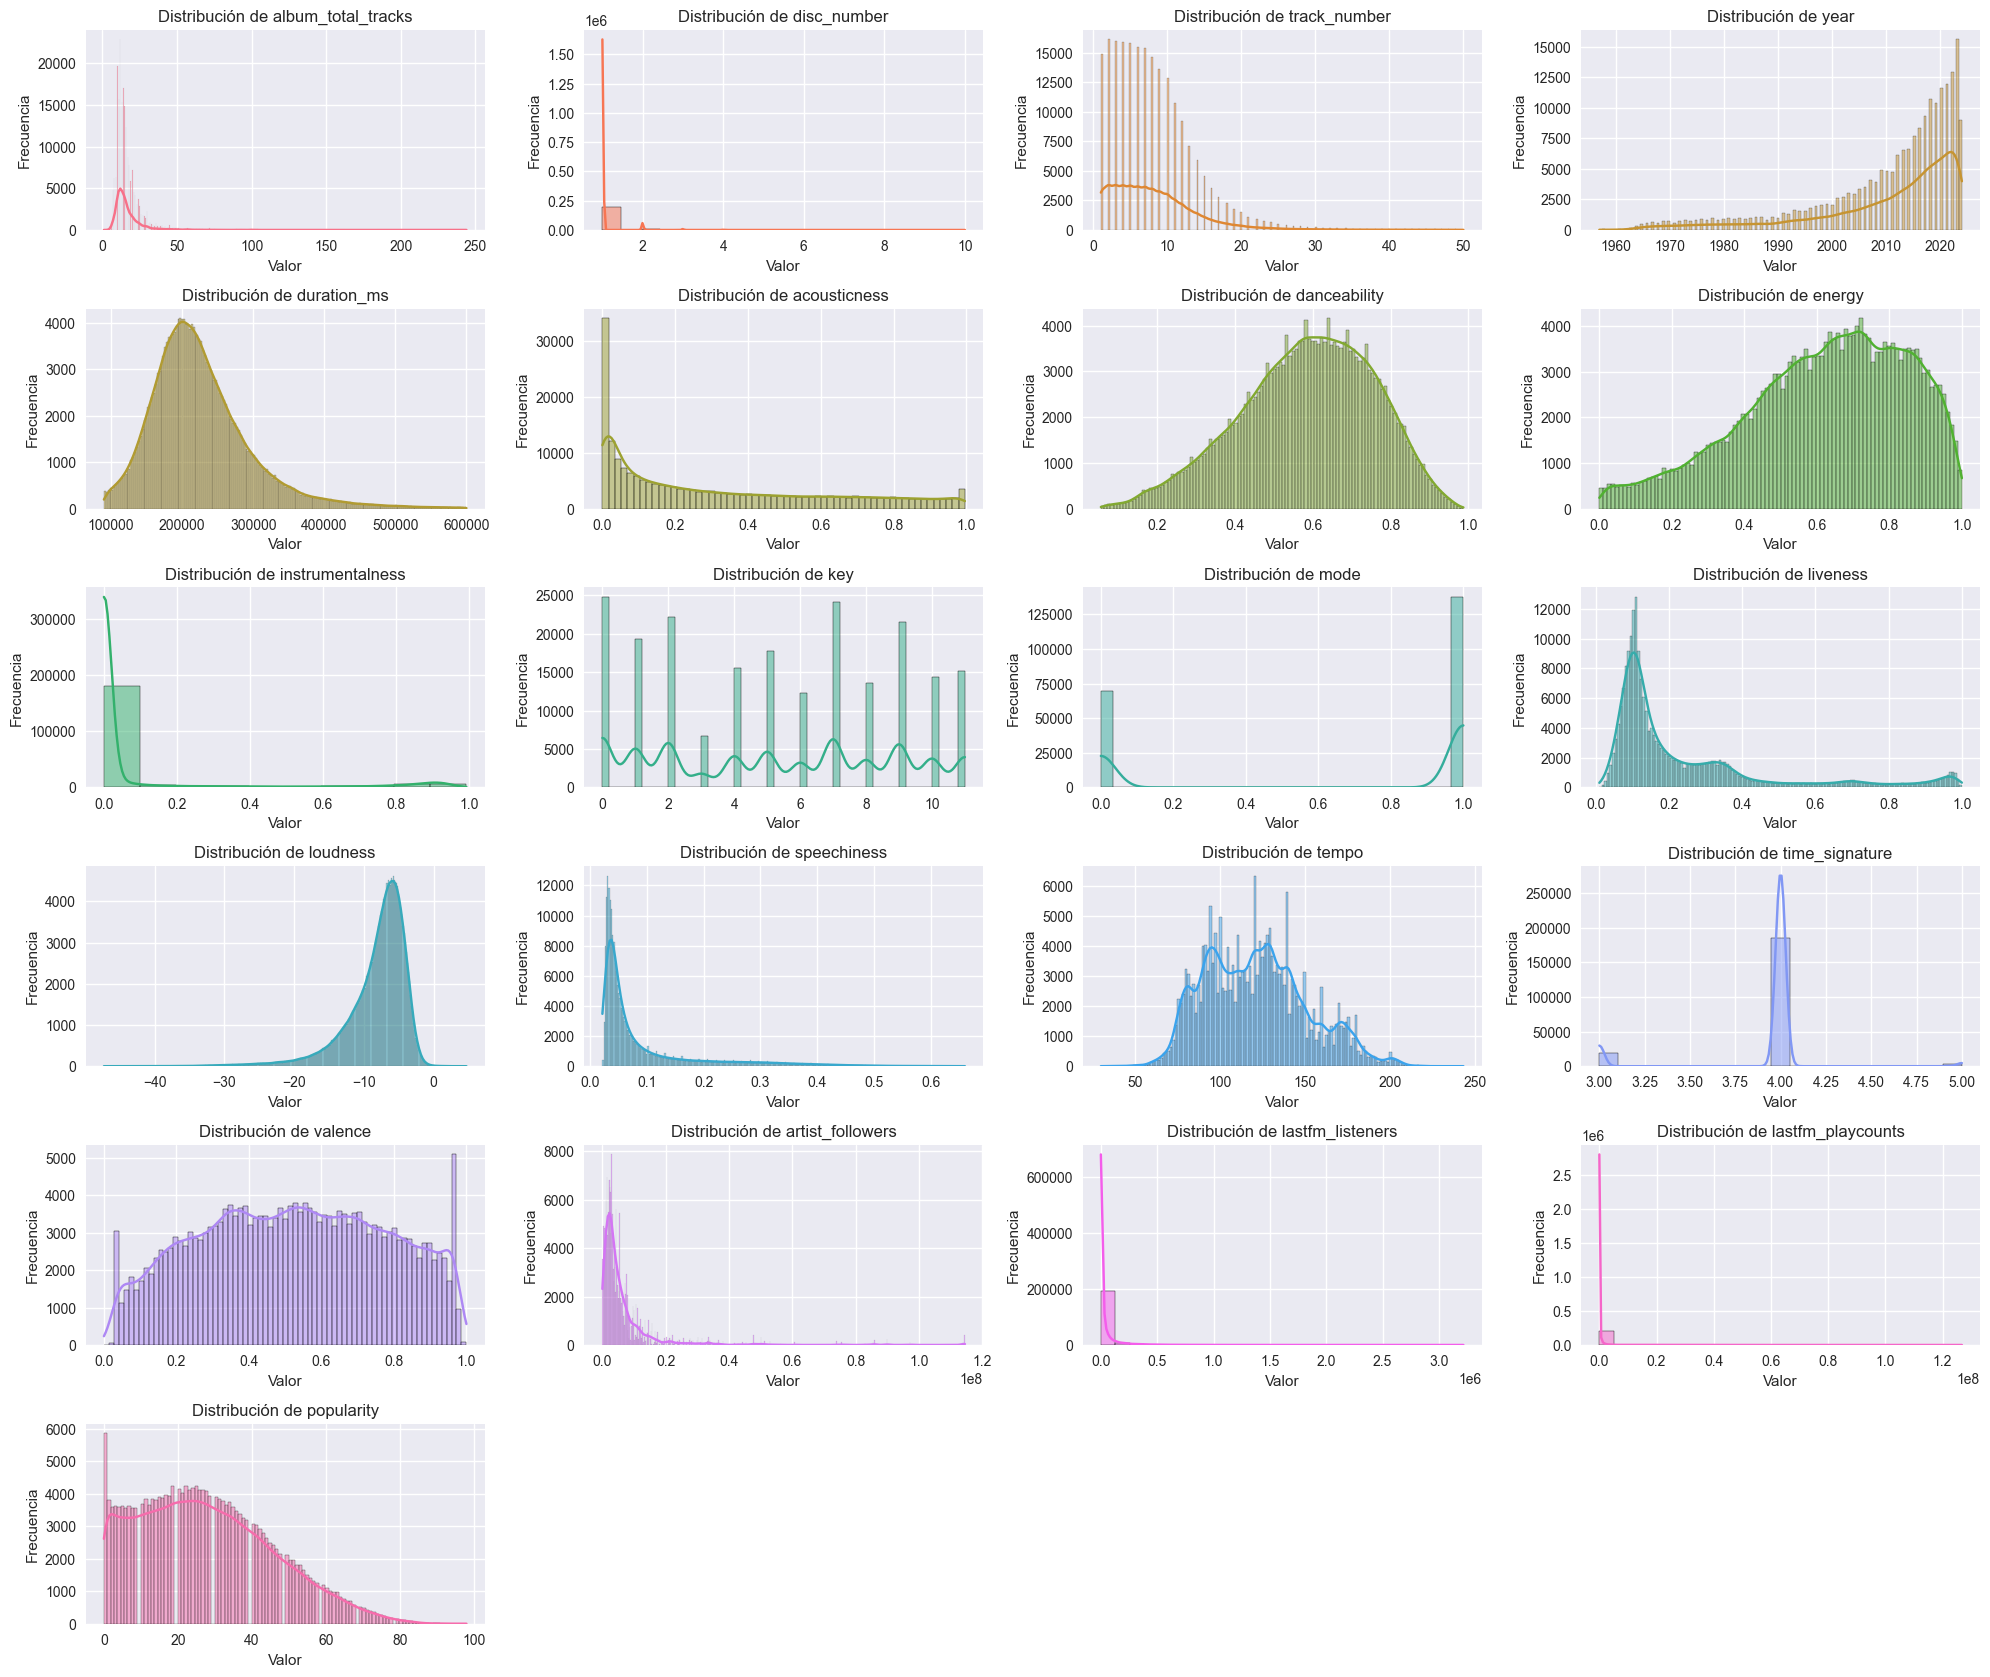

In [54]:
# Seleccionar las variables numéricas
num_vars = eda.select_dtypes(include=['int64', 'float64']).columns

# Configurar el tamaño de la figura y la cuadrícula de subplots
n_cols = 4
n_rows = len(num_vars) // n_cols + (len(num_vars) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5 * 9/16))
axes = axes.flatten()

# Colores para los histogramas
colors = sns.color_palette("husl", len(num_vars))

# Crear un gráfico de distribución para cada variable numérica
for ax, var, color in zip(axes, num_vars, colors):
    if var == 'instrumentalness':
        sns.histplot(eda[var], kde=True, ax=ax, color=color, bins=10)
    elif var == 'lastfm_playcounts' or var == 'lastfm_listeners':
        sns.histplot(df[var], kde=True, ax=ax, color=color, bins=25)
    else:
        sns.histplot(df[var], kde=True, ax=ax, color=color)
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')

# Eliminar subplots vacíos
for ax in axes[len(num_vars):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

#### `release_date` (Fecha de lanzamiento)

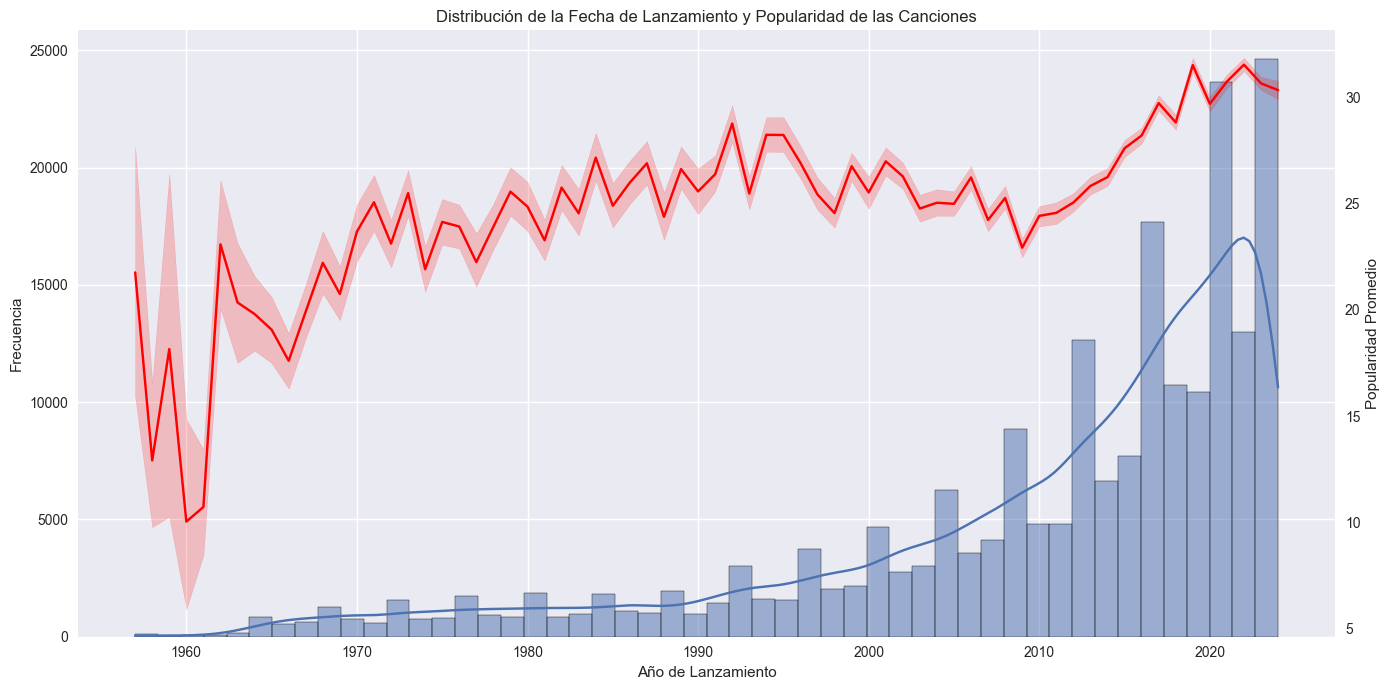

In [53]:
# Extraer el año de la variable release_date si aún no está presente en la columna year
if 'year' not in eda.columns:
    eda['year'] = eda['release_date'].dt.year

# Crear una figura con un solo subplot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de distribución de la variable year
sns.histplot(eda['year'], bins=50, kde=True, ax=ax1)
ax1.set_title('Distribución de la Fecha de Lanzamiento y Popularidad de las Canciones')
ax1.set_xlabel('Año de Lanzamiento')
ax1.set_ylabel('Frecuencia')

# Crear un segundo eje y para la popularidad
ax2 = ax1.twinx()
sns.lineplot(data=eda, x='year', y='popularity', color='red', ax=ax2)
ax2.set_ylabel('Popularidad Promedio')
ax2.grid(False)  # Desactivar la cuadrícula del segundo eje y para que no interfiera con el histograma

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

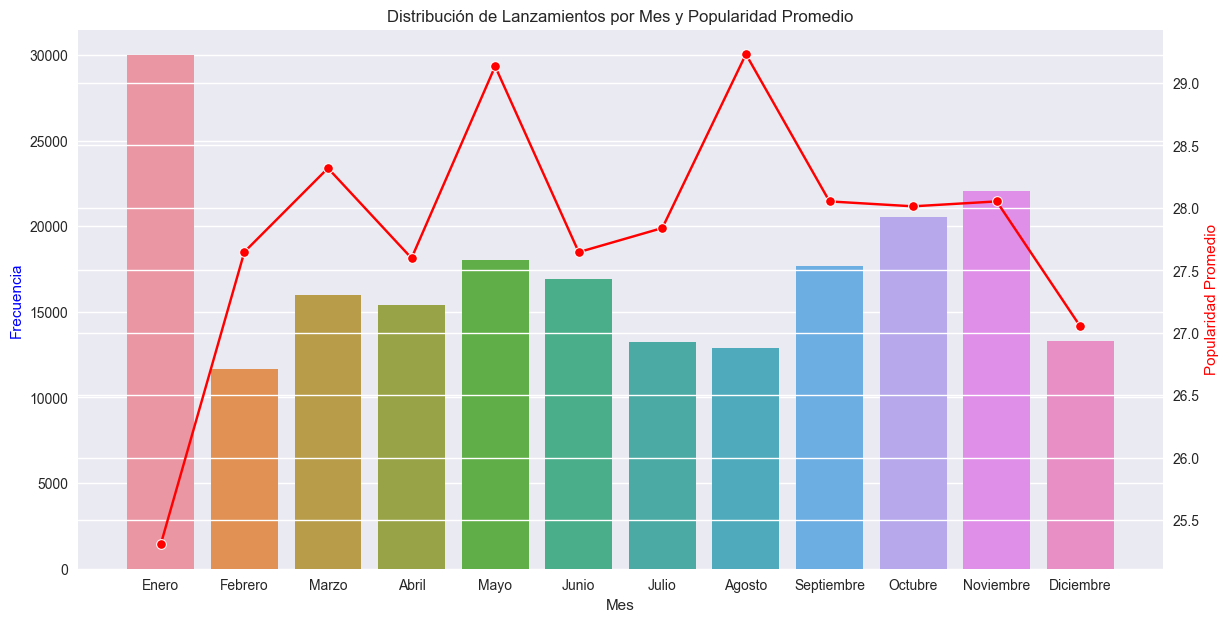

In [54]:

# Crear una nueva columna para el mes de lanzamiento
eda['month'] = pd.to_datetime(eda['release_date'], errors='coerce').dt.month

month_names = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio', 
               7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}
eda['month_name'] = eda['month'].map(month_names)

# # Graficar la distribución de lanzamientos por mes
# plt.figure(figsize=(14, 7))
# sns.countplot(data=eda, x='month_name', order=list(month_names.values()))
# plt.title('Distribución de Lanzamientos por Mes')
# plt.xlabel('Mes')
# plt.ylabel('Frecuencia')
# plt.show()

# Calcular la popularidad promedio por mes
popularity_by_month = eda.groupby('month_name')['popularity'].mean().reindex(list(month_names.values()))

# Graficar la distribución de lanzamientos por mes y la popularidad promedio
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de barras para la distribución de lanzamientos
sns.countplot(data=eda, x='month_name', order=list(month_names.values()), ax=ax1)
ax1.set_title('Distribución de Lanzamientos por Mes y Popularidad Promedio')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Frecuencia', color='b')

# Crear un segundo eje para la popularidad
ax2 = ax1.twinx()
sns.lineplot(x=popularity_by_month.index, y=popularity_by_month.values, ax=ax2, color='r', marker='o')
ax2.set_ylabel('Popularidad Promedio', color='r')

plt.show()



#### `duration_ms` (Duración)

Distribución de duración Een minutos por año

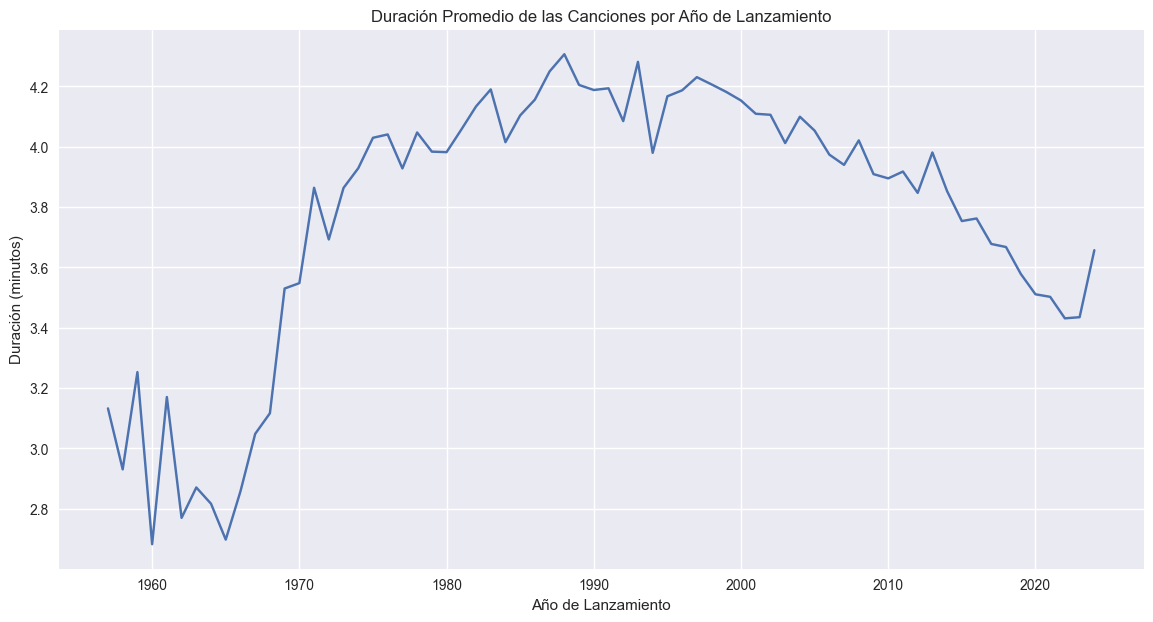

In [55]:
# plt.figure(figsize=(14, 7))
# sns.lineplot(data=eda, x='year', y='duration_ms', estimator='mean', ci=None)
# plt.title('Duración Promedio de las Canciones por Año de Lanzamiento')
# plt.xlabel('Año de Lanzamiento')
# plt.ylabel('Duración (ms)')
# plt.show()

# Convertir la duración de milisegundos a minutos
eda['duration_min'] = eda['duration_ms'] / 60000

plt.figure(figsize=(14, 7))
sns.lineplot(data=eda, x='year', y='duration_min', estimator='mean', ci=None)
plt.title('Duración Promedio de las Canciones por Año de Lanzamiento')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Duración (minutos)')
plt.show()


#### `key` y `mode` (Tonalidad)

In [56]:
key_dict = {0: 'Do', 1: 'Do♯', 2: 'Re', 3: 'Mib', 4: 'Mi', 5: 'Fa', 6: 'Fa♯', 7: 'Sol', 8: 'Sol#', 9: 'La', 10: 'Sib', 11: 'Si'}
mode_dict = {0: 'menor', 1: 'Mayor'}
eda['key_name'] = eda['key'].map(key_dict)
eda['mode_name'] = eda['mode'].map(mode_dict)

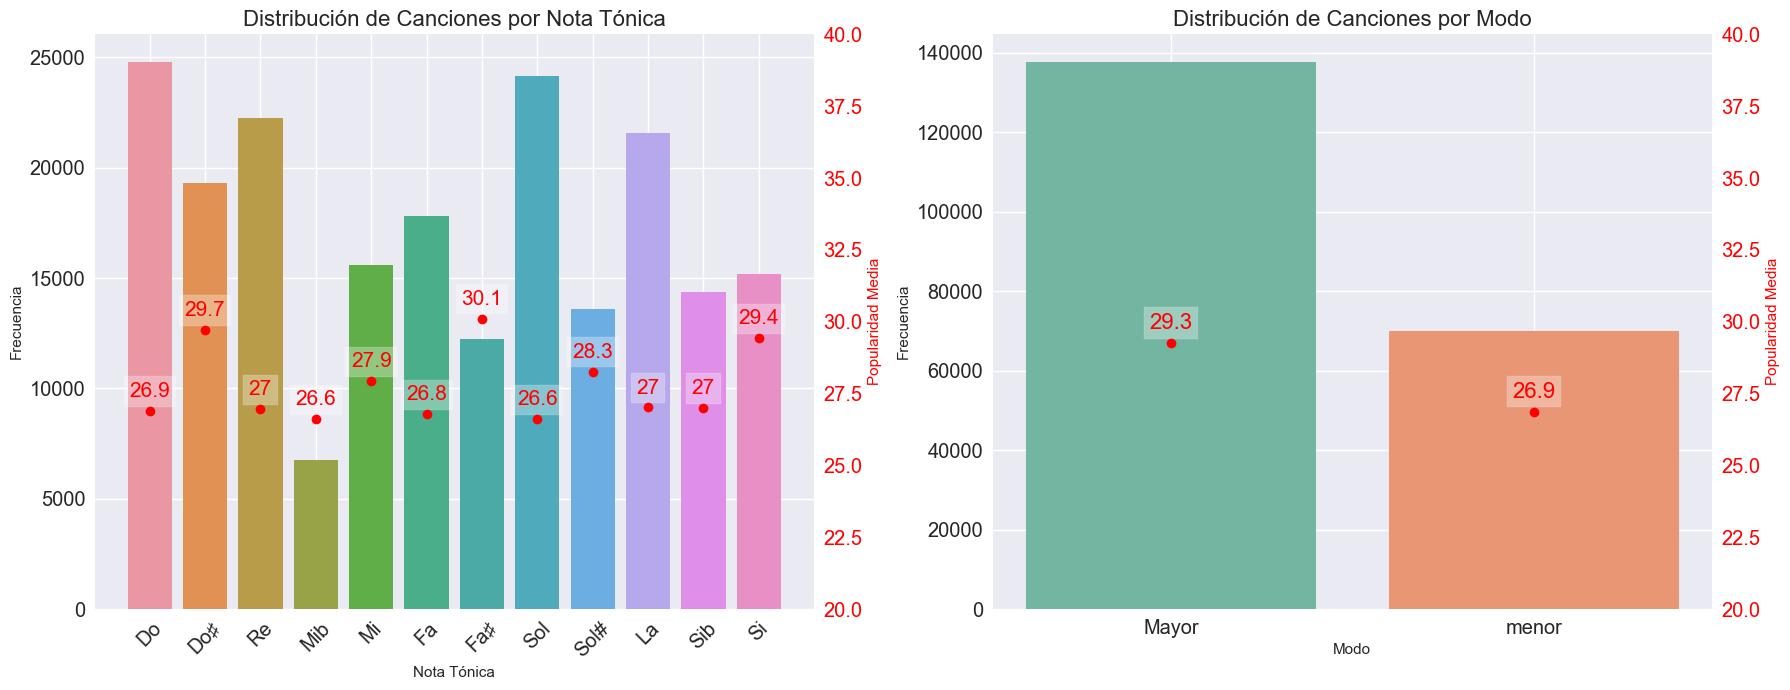

In [57]:

# Antes de crear los gráficos, ajusta el tamaño de fuente global para los ticks
plt.rc('xtick', labelsize='x-large')  # Aumenta el tamaño de fuente de los xticks
plt.rc('ytick', labelsize='x-large')  # Aumenta el tamaño de fuente de los yticks

# Calcular la popularidad media por 'key_name' y 'mode_name'
avg_popularity_key = eda.groupby('key_name')['popularity'].mean()
avg_popularity_mode = eda.groupby('mode_name')['popularity'].mean()

# Plot key distribution along with mode distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Tonalidad
sns.countplot(data=eda, x='key_name', order=key_dict.values(), ax=axes[0], zorder=3)
axes[0].set_title('Distribución de Canciones por Nota Tónica', fontsize=16)
axes[0].set_xlabel('Nota Tónica')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, which='both', zorder=0)  # Asegurar que la cuadrícula esté detrás de las barras
axes[0].tick_params(axis='x', rotation=45)

# Crear un segundo eje Y para la popularidad media en el primer gráfico
ax2 = axes[0].twinx()
ax2.set_ylabel('Popularidad Media', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(20, 40)  # Establecer el límite del eje Y entre 0 y 100
ax2.grid(False)  # Desactivar la cuadrícula del segundo eje Y para que no interfiera con el histograma

# Añadir popularidad media sobre el diagrama de tonalidad
for key, pop in avg_popularity_key.items():
    ax2.annotate(format_popularity(pop),
                 xy=(list(key_dict.values()).index(key), pop),
                 xytext=(0, 10),
                 textcoords='offset points',
                 fontsize=15,
                 ha='center',
                 backgroundcolor='#ffffff50',
                 color='red')
    ax2.plot(list(key_dict.values()).index(key), pop, 'ro', zorder=4)  # Asegurar que los puntos estén encima de las barras

# Modo
sns.countplot(data=eda, x='mode_name', ax=axes[1], palette='Set2', zorder=3)
axes[1].set_title('Distribución de Canciones por Modo', fontsize=16)
axes[1].set_xlabel('Modo')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, which='both', zorder=0)  # Asegurar que la cuadrícula esté detrás de las barras

# Crear un segundo eje Y para la popularidad media en el segundo gráfico
ax4 = axes[1].twinx()
ax4.set_ylabel('Popularidad Media', color='red')
ax4.tick_params(axis='y', labelcolor='red')
ax4.set_ylim(20, 40)  # Establecer el límite del eje Y entre 0 y 100
ax4.grid(False)  # Desactivar la cuadrícula del segundo eje Y para que no interfiera con el histograma

# Añadir popularidad media sobre el diagrama de modo
for mode, pop in avg_popularity_mode.items():
    ax4.annotate(format_popularity(pop),
                 xy=(list(mode_dict.values()).index(mode), pop),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center',
                 fontsize=16,
                 backgroundcolor='#ffffff50',
                 color='red')
    ax4.plot(list(mode_dict.values()).index(mode), pop, 'ro', zorder=4)  # Asegurar que los puntos estén encima de las barras


plt.tight_layout()
plt.show()

In [58]:
avg_popularity_key

key_name
Do      26.893262
Do♯     29.711651
Fa      26.778071
Fa♯     30.103209
La      27.014777
Mi      27.933504
Mib     26.600178
Re      26.959146
Si      29.429447
Sib     26.999233
Sol     26.611212
Sol#    28.257901
Name: popularity, dtype: float64

#### `explicit` (Lenguaje malsonante)

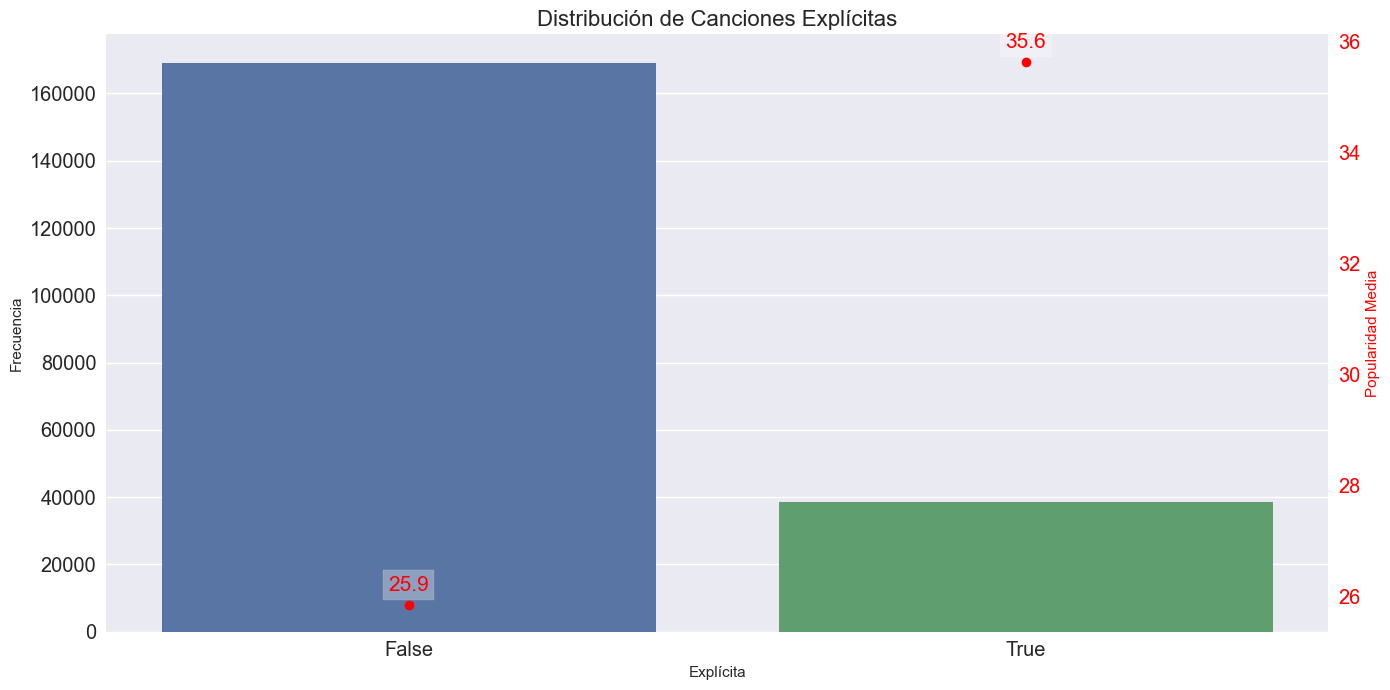

In [59]:
# plot the distribution of the variable 'explicit' and the average popularity of the songs by the value of the variable 'explicit'

# Calcular la popularidad media por 'explicit'
avg_popularity_explicit = eda.groupby('explicit')['popularity'].mean()

# Crear un gráfico de barras para la distribución de 'explicit' y la popularidad media
plt.figure(figsize=(14, 7))

# Distribución de 'explicit'
sns.countplot(data=eda, x='explicit', ax=plt.gca())
plt.title('Distribución de Canciones Explícitas', fontsize=16)
plt.xlabel('Explícita')
plt.ylabel('Frecuencia')

# Crear un segundo eje Y para la popularidad media
ax2 = plt.gca().twinx()
ax2.set_ylabel('Popularidad Media', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(False)  # Desactivar la cuadrícula del segundo eje Y para que no interfiera con el histograma

# Añadir popularidad media sobre el diagrama de 'explicit'
for explicit, pop in avg_popularity_explicit.items():
    plt.annotate(format_popularity(pop),
                 xy=(explicit, pop),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center',
                 fontsize=15,
                 backgroundcolor='#ffffff50',
                 color='red')
    plt.plot(explicit, pop, 'ro')  # Asegurar que los puntos estén encima de las barras

plt.tight_layout()
plt.show()

AttributeError: 'numpy.bool_' object has no attribute 'startswith'

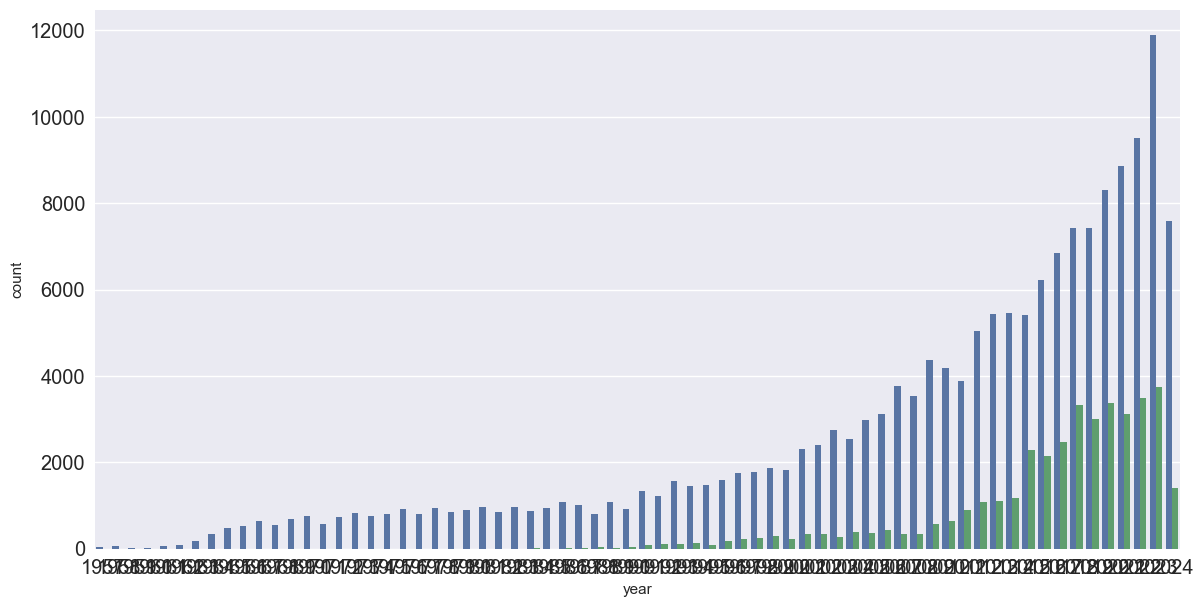

In [61]:
# Explicitness by genre
eda['explicit'] = eda['explicit'].astype('bool')
eda['explicit'] = eda['explicit'].astype('str')

# Calcular la popularidad media por 'explicit' y 'genre'
avg_popularity_explicit_genre = eda.groupby(['explicit', 'genre'])['popularity'].mean().unstack()

# Crear un gráfico de barras apiladas para la popularidad media por 'explicit' y 'genre'
plt.figure(figsize=(14, 7))
avg_popularity_explicit_genre.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Popularidad Media por Género y Explícita', fontsize=16)
plt.xlabel('Explícita')
plt.ylabel('Popularidad Media')
plt.legend(title='Género', title_fontsize='large', fontsize='large', loc='upper left')
plt.xticks(ticks=[0, 1], labels=['No Explícita', 'Explícita'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### `acousticness` (Acusticidad)

> La variable `acousticness` consiste en un número real en el intervalo `[0, 1]` (0-100%) que representa una medida de confianza sobre si la pista es acústica.
>
> `1.0` representa una confianza alta en que la canción es acústica.

Las canciones compuestas mayoritariamente por guitarras acústicas, baterías y sonidos "naturales" tendrán un valor alto de acusticidad.

Las canciones producidas digitalmente, con kits de instrumentos digitales y guitarras eléctricas o sintatizadores electrónicos tendrán acusticidad cercana a 0.

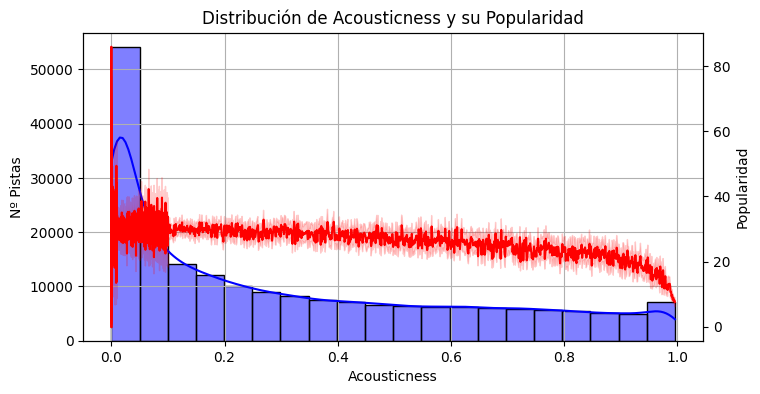

In [71]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot histogram of acousticness
sns.histplot(data=eda, x='acousticness', kde=True, color='blue', bins=20, ax=ax1)
ax1.set_xlabel('Acousticness')
ax1.set_ylabel('Nº Pistas')
ax1.grid(True)

# Create second y-axis for popularity
ax2 = ax1.twinx()
sns.lineplot(data=eda, x='acousticness', y='popularity', ax=ax2, color='r')
ax2.set_ylabel('Popularidad')

plt.title('Distribución de Acousticness y su Popularidad')
plt.show()

In [72]:
#count tracks with acousticness <= 0.05 out of total tracks
acousticness_005 = len(eda[eda['acousticness'] <= 0.05])
total_tracks = len(eda)
print(f'Hay {acousticness_005} canciones con acousticness <= 0.05 de un total de {total_tracks} canciones.')
print(f'{round(acousticness_005/total_tracks*100, 2)}%')

#mean popularity of tracks with acousticness <= 0.05
popularity_acousticness_005 = eda[eda['acousticness'] <= 0.05]['popularity'].mean()
print(f'La popularidad promedio de las canciones con acousticness <= 0.05 es {round(popularity_acousticness_005, 2)}.')
print(f'La popularidad promedio de todas las canciones es {round(eda["popularity"].mean(), 2)}.')

Hay 54185 canciones con acousticness <= 0.05 de un total de 207627 canciones.
26.1%
La popularidad promedio de las canciones con acousticness <= 0.05 es 30.2.
La popularidad promedio de todas las canciones es 27.67.


Observamos que un cuarto de las canciones tienen valores de `acousticness` muy bajos, entre `(0.0, 0.05)`, lo que indican que utilizan elementos digitales en su mayoría.<br>
Esto probablemente sea consecuencia de la modernización y electrificación de la música en las últimas decadas.

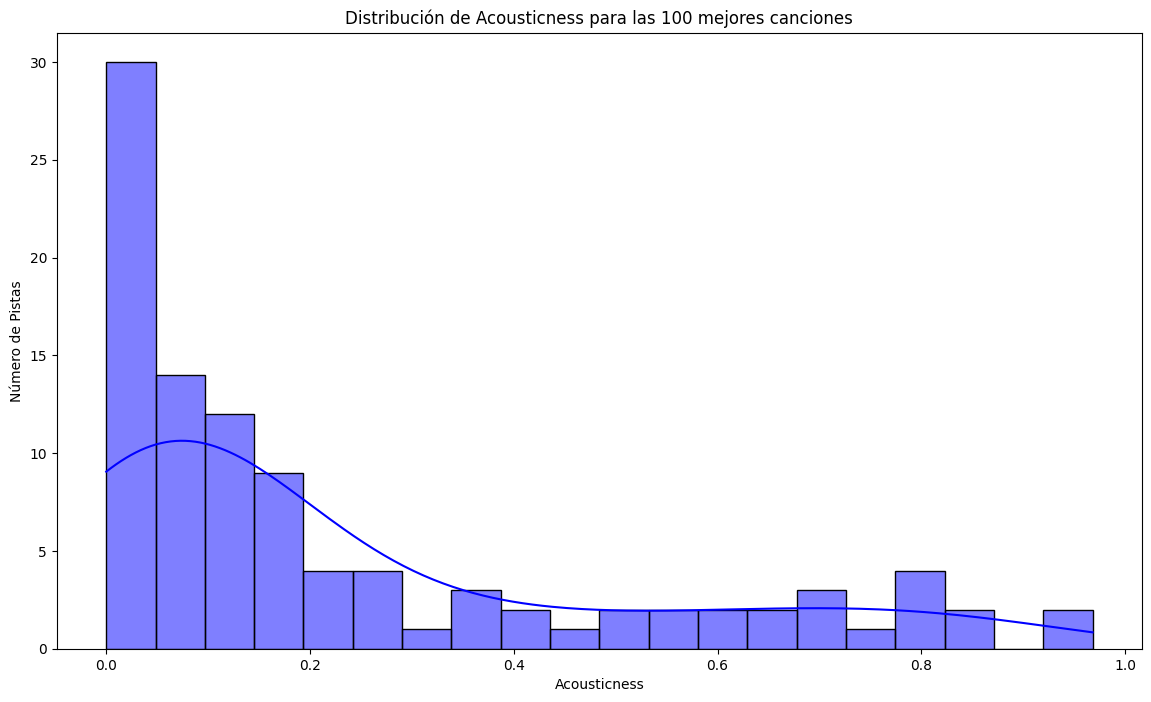

In [73]:
# Filtrar las mejores 100 canciones en popularidad
top_100_songs = eda.nlargest(100, 'popularity')

plt.figure(figsize=(14, 8))
sns.histplot(data=top_100_songs, x='acousticness', kde=True, color='blue', bins=20)
plt.xlabel('Acousticness')
plt.ylabel('Número de Pistas')
plt.title('Distribución de Acousticness para las 100 mejores canciones')
plt.show()


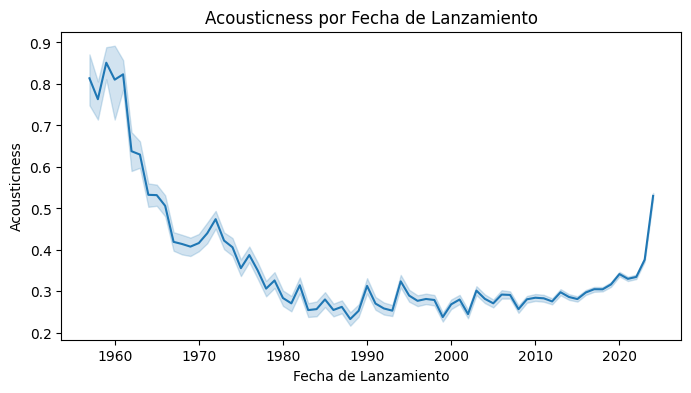

In [74]:
#acousticness by release date year and show popularity
release_date_year = pd.to_datetime(eda['release_date'], errors='coerce').dt.year
eda['release_date_year'] = release_date_year
plt.figure(figsize=(8, 4))
sns.lineplot(data=eda, x='release_date_year', y='acousticness')
plt.xlabel('Fecha de Lanzamiento')
plt.ylabel('Acousticness')
plt.title('Acousticness por Fecha de Lanzamiento')
plt.show()

#### `danceability` (Bailabilidad)

> La bailabilidad describe lo adecuada que es una pista para bailar basándose en una combinación de elementos musicales como el tempo, la estabilidad del ritmo, la fuerza del compás y la regularidad general.
>
> El dominio de la variable `danceability` también se encuentra en el intervalo `[0.0, 1.0]`, siendo `0.0` la menos bailable y `1.0` la más bailable.

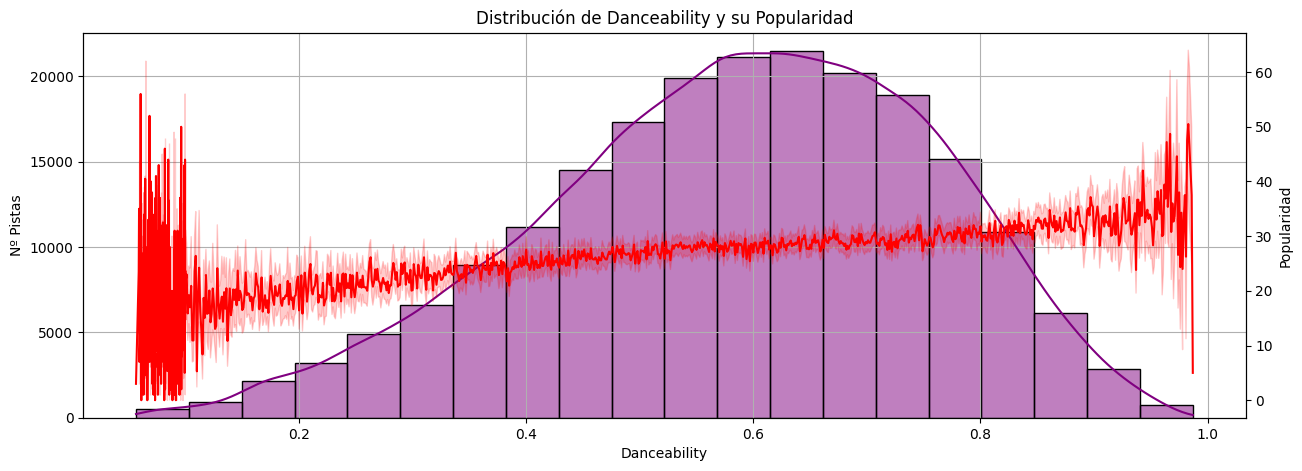

In [75]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot histogram of acousticness
sns.histplot(data=eda, x='danceability', kde=True, color='purple', bins=20, ax=ax1)
ax1.set_xlabel('Danceability')
ax1.set_ylabel('Nº Pistas')
ax1.grid(True)

# Create second y-axis for popularity
ax2 = ax1.twinx()
sns.lineplot(data=eda, x='danceability', y='popularity', ax=ax2, color='r')
ax2.set_ylabel('Popularidad')

plt.title('Distribución de Danceability y su Popularidad')
plt.show()

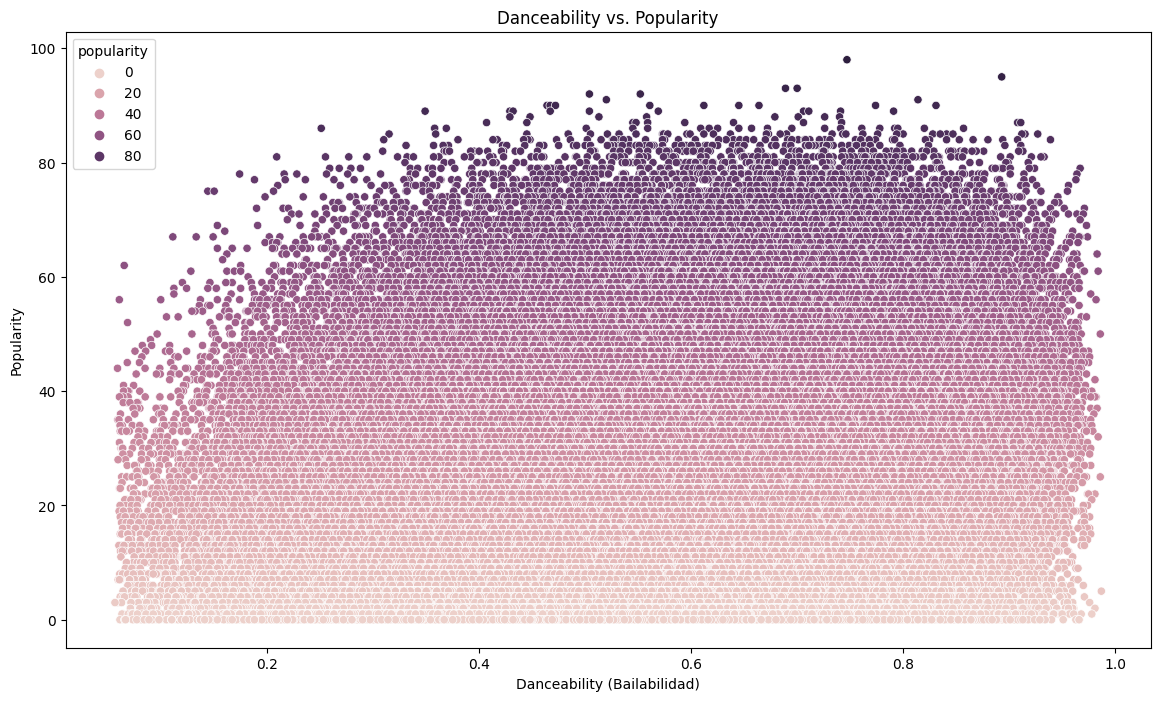

In [76]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=eda, x='danceability', y='popularity', hue="popularity")
plt.xlabel('Danceability (Bailabilidad)')
plt.ylabel('Popularity')
plt.title('Danceability vs. Popularity')
plt.show()

#### `energy` (Energía)

> La energía es una medida  en el intervalo `[0.0, 1.0]` y representa una medida perceptiva de intensidad y actividad. Normalmente, las pistas enérgicas son rápidas, ruidosas (noisy) y muy altas de volumen (loudness, decibelios). 
> Por ejemplo, el Death Metal tiene una energía alta, mientras que un preludio de Bach tiene un índice muy bajo en la escala de energía. 
>
> Las características perceptivas que contribuyen a este atributo incluyen el rango dinámico, el volumen percibido, el timbre, la velocidad de inicio y la entropía general.

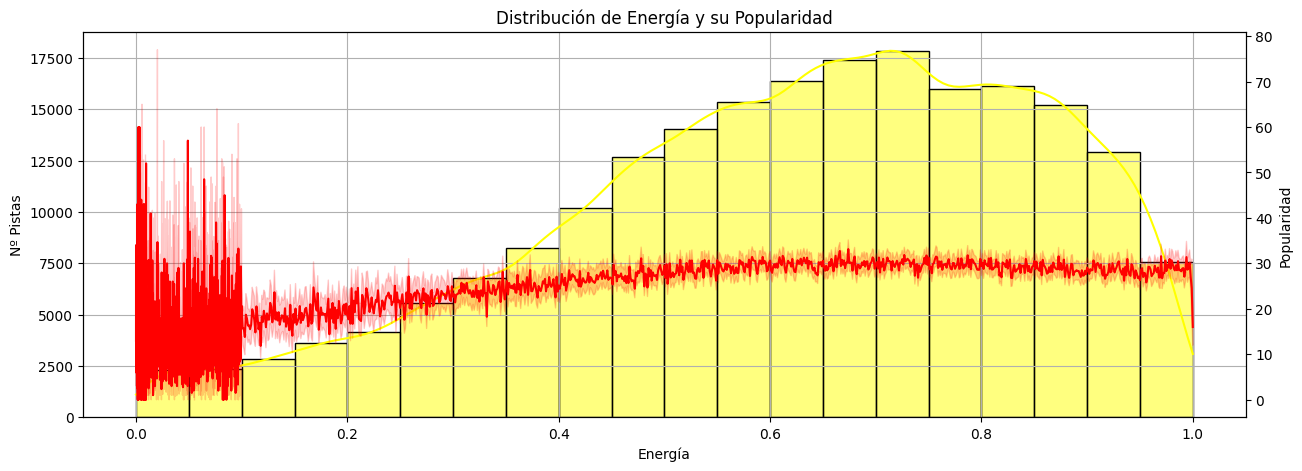

In [77]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot histogram of acousticness
sns.histplot(data=eda, x='energy', kde=True, color='yellow', bins=20, ax=ax1)
ax1.set_xlabel('Energía')
ax1.set_ylabel('Nº Pistas')
ax1.grid(True)

# Create second y-axis for popularity
ax2 = ax1.twinx()
sns.lineplot(data=eda, x='energy', y='popularity', ax=ax2, color='r')
ax2.set_ylabel('Popularidad')

plt.title('Distribución de Energía y su Popularidad')
plt.show()

#### `instrumentalness` (Instrumentalidad)

> Predice si una pista NO contiene voces.
> 
> Los sonidos "oooh" y "aaah" se consideran instrumentos en este contexto. 
> Las pistas de rap o con oratoria son claramente "vocales". 
>
> La variable se encuentra en el intervalo `[0.0, 1.0]`.
>
> Cuanto más se acerque el valor de `instrumentalness` a `1.0`, mayor será la probabilidad de que la pista NO contenga voces. 
>
> Los valores de `instrumentalness > 0.5` representan pistas instrumentales, pero la confianza es mayor a medida que el valor se acerca a `1.0`.

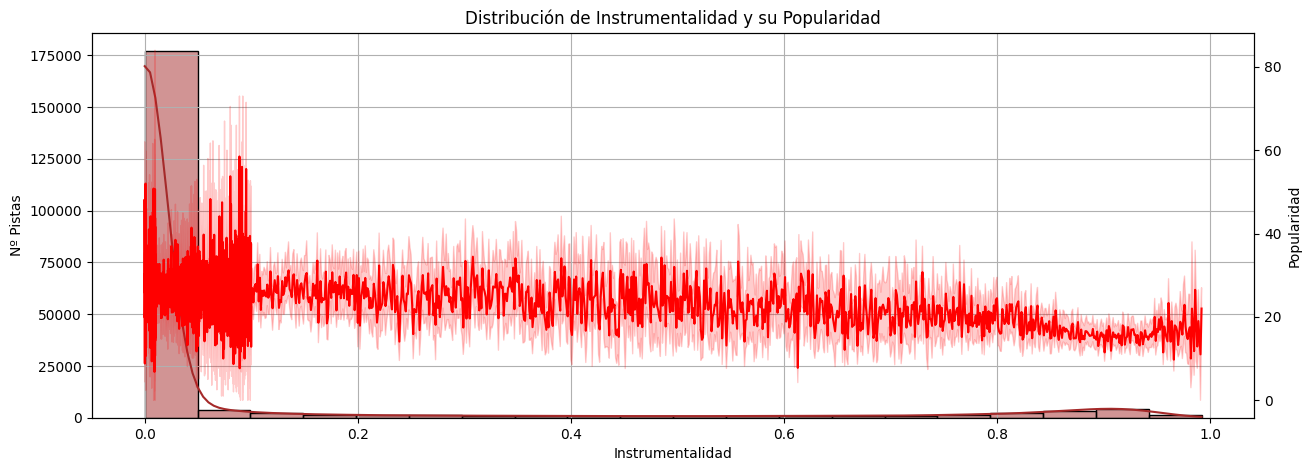

In [53]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot histogram of acousticness
sns.histplot(data=eda, x='instrumentalness', kde=True, color='brown', bins=20, ax=ax1)
ax1.set_xlabel('Instrumentalidad')
ax1.set_ylabel('Nº Pistas')
ax1.grid(True)

# Create second y-axis for popularity
ax2 = ax1.twinx()
sns.lineplot(data=eda, x='instrumentalness', y='popularity', ax=ax2, color='r')
ax2.set_ylabel('Popularidad')

plt.title('Distribución de Instrumentalidad y su Popularidad')
plt.show()

In [241]:
#between 0.2 and 0.5
instrumentals = df[(df['instrumentalness'] >= 0.2) & (df['instrumentalness'] <= 0.3)] 
print(f'Hay {len(instrumentals)} canciones con instrumentalidad > 0.5.')

Hay 2280 canciones con instrumentalidad > 0.5.


In [240]:
instrumentals.sample(5, random_state=random_state)

id                            title  \
235764  5CS1JrAxcUOHZdNU4PwXuX        Full Metal (Instrumental)   
164298  6qXVuEYcL6M4Yc1zyY5F8D                           Easier   
124954  43R0B1EJYb4X9V2xD9iJwk         Tere Bharose He Nandlala   
188399  1t00kKXps3tHZVQ3mb4uOF  I'm Lying To You Cause I'm Lost   
82098   52ooD6LHuXFubM6d1CDD93                       YEAH RIGHT   

                   artist               artist_id                      album  \
235764      The Alchemist  0eVyjRhzZKke2KFYTcDkeu  Covert Coup Instrumentals   
164298  Avenged Sevenfold  0nmQIMXWTXfhgOBdNzhGOs       Life Is But a Dream…   
124954      Mohammed Rafi  0gXDpqwYNDODn7fB0RDN8J       Tere Bharose Nandlal   
188399    The Paper Kites  79hrYiudVcFyyxyJW0ipTy                 twelvefour   
82098                Joji  3MZsBdqDrRTJihTHQrO6Dq                  BALLADS 1   

        album_total_tracks  disc_number  track_number  duration_ms  \
235764                  10            1             4       158933   
164298                  11            1             7       217760   
124954                  12            1            12       208626   
188399                  10            1             6       212706   
82098                   12            1             6       174357   

       release_date  explicit  acousticness  danceability  energy  \
235764   2012-05-08     False       0.00528         0.387   0.895   
164298   2023-06-02     False       0.01350         0.435   0.709   
124954   2002-12-21     False       0.98800         0.439   0.341   
188399   2015-08-28     False       0.02940         0.538   0.619   
82098    2018-10-26      True       0.62000         0.671   0.589   

        instrumentalness  key  mode  liveness  loudness  speechiness    tempo  \
235764             0.324    2     1    0.4610    -9.035       0.4890   73.028   
164298             0.324    9     1    0.2080    -8.189       0.0455  149.762   
124954             0.376    7     1    0.0936    -9.659       0.0381   64.444   
188399             0.332    7     1    0.2720    -6.769       0.0251  112.070   
82098              0.234    1     1    0.0992    -9.573       0.1280  169.031   

        time_signature  valence  \
235764               4    0.340   
164298               4    0.322   
124954               4    0.278   
188399               4    0.610   
82098                4    0.201   

                                            artist_genres  artist_followers  \
235764  ['alternative hip hop', 'drumless hip hop', 'h...            683166   
164298                              ['alternative metal']           7544164   
124954                     ['classic bollywood', 'filmi']           7581987   
188399  ['australian indie folk', 'indie anthem-folk',...            785304   
82098                                       ['viral pop']           9578696   

        lastfm_listeners  lastfm_playcounts  popularity  \
235764            1688.0             4561.0          10   
164298           26636.0           175929.0          47   
124954               7.0               23.0           1   
188399           10332.0            55631.0          26   
82098           802009.0         13396039.0          71   

                             root_title    year  
235764        Full Metal - Instrumental  2012.0  
164298                           Easier  2023.0  
124954         Tere Bharose He Nandlala  2002.0  
188399  I'm Lying To You Cause I'm Lost  2015.0  
82098                        YEAH RIGHT  2018.0

#### `liveness` (En Directo)

> Determina la presencia de una audiencia en la grabación. 
>
> Valores más altos de `liveness` representan una probabilidad mayor de que la canción haya sido interpretada en vivo. <br>
> Un valor de `liveness > 0.8` indica una alta probabilidad de que la canción sea en directo.

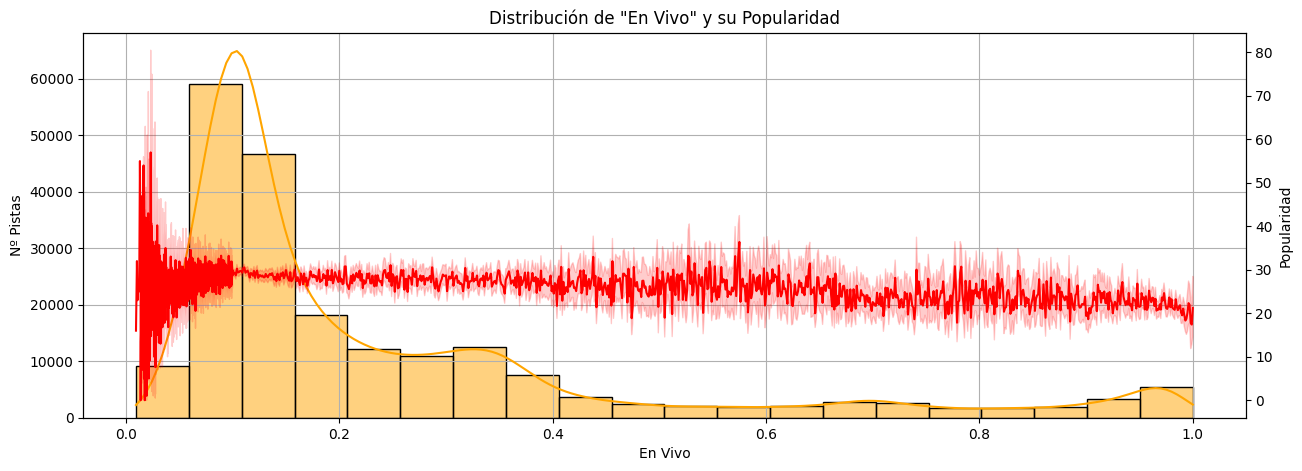

In [220]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot histogram of acousticness
sns.histplot(data=eda, x='liveness', kde=True, color='orange', bins=20, ax=ax1)
ax1.set_xlabel('En Vivo')
ax1.set_ylabel('Nº Pistas')
ax1.grid(True)

# Create second y-axis for popularity
ax2 = ax1.twinx()
sns.lineplot(data=eda, x='liveness', y='popularity', ax=ax2, color='r')
ax2.set_ylabel('Popularidad')

plt.title('Distribución de "En Vivo" y su Popularidad')
plt.show()

#### `loudness` (Sonoridad, volumen en decibelios)


> La sonoridad global de una pista en decibelios (dB).<br>
> Los valores de sonoridad se promedian en toda la pista y son útiles para comparar la sonoridad relativa de las pistas. 
>
> La sonoridad es la cualidad de un sonido que es el principal correlato psicológico de la fuerza física (amplitud). 
>
> Los valores suelen oscilar entre `[-60 dB, 0 dB]`. En este caso, `0 dB` es el estándar para la audición humana.

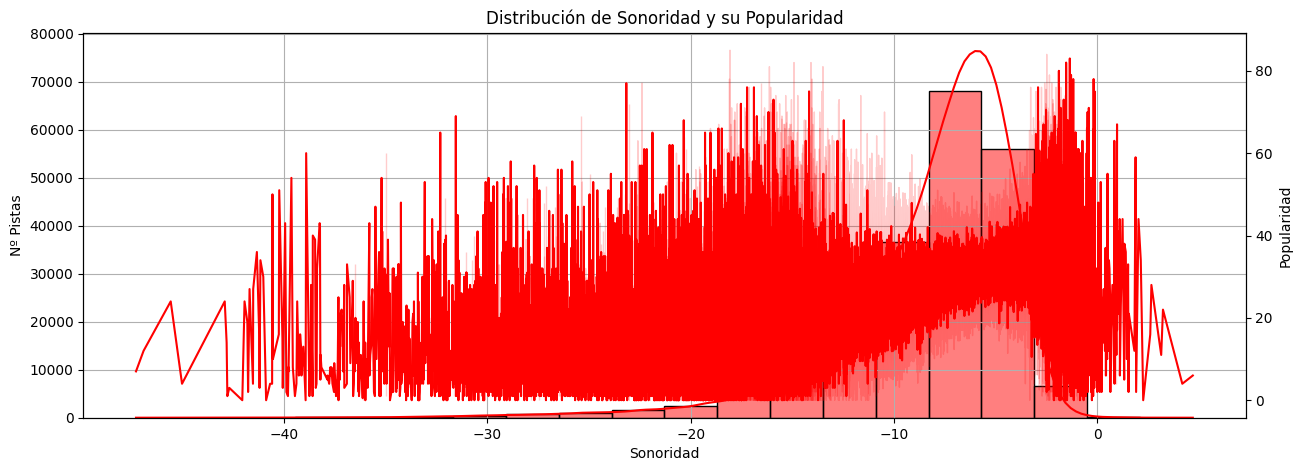

In [80]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot histogram of acousticness
sns.histplot(data=eda, x='loudness', kde=True, color='red', bins=20, ax=ax1)
ax1.set_xlabel('Sonoridad')
ax1.set_ylabel('Nº Pistas')
ax1.grid(True)

# Create second y-axis for popularity
ax2 = ax1.twinx()
sns.lineplot(data=eda, x='loudness', y='popularity', ax=ax2, color='r')
ax2.set_ylabel('Popularidad')

plt.title('Distribución de Sonoridad y su Popularidad')
plt.show()

#### `speechiness` (Vocalidad, Locuacidad)

> Determina la presencia de palabras habladas en una pista. 
>
> Cuanto más exclusivamente hablada sea la grabación (por ejemplo, un podcast, un audiolibro, poesía...), más se acercará `speechiness` a `1.0`.
>
> Los valores de `speechiness > 0.66` describen pistas que probablemente estén compuestas en su totalidad por palabras habladas, como los podcasts o audiolibros que hemos comentado antes. 
>
> Los valores entre de `speechiness` en el intervalo `[0.33, 0.66]` describen pistas que pueden contener tanto música como voz, ya sea en secciones o en capas (como la mayoría de canciones en la actualidad). Esto incluye casos como la música rap. 
>
> Los valores `speechiness < 0.33` representan probablemente música instrumental y otras pistas no habladas.

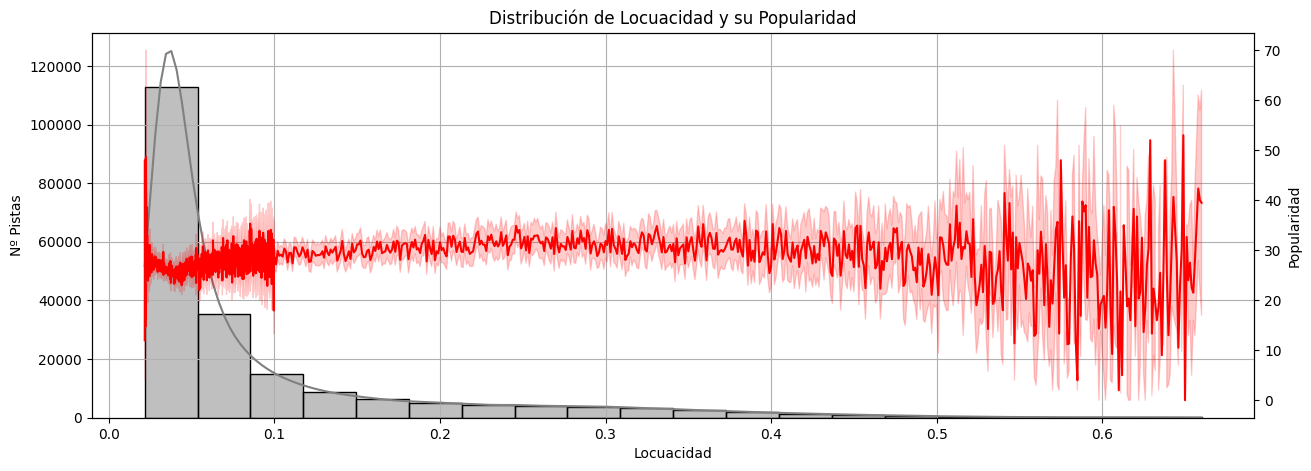

In [81]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot histogram of acousticness
sns.histplot(data=eda, x='speechiness', kde=True, color='gray', bins=20, ax=ax1)
ax1.set_xlabel('Locuacidad')
ax1.set_ylabel('Nº Pistas')
ax1.grid(True)

# Create second y-axis for popularity
ax2 = ax1.twinx()
sns.lineplot(data=eda, x='speechiness', y='popularity', ax=ax2, color='r')
ax2.set_ylabel('Popularidad')

plt.title('Distribución de Locuacidad y su Popularidad')
plt.show()

#### `valence` (Valencia)

> La valencia es una medida en el intervalo `[0.0, 1.0]` que describe la positividad musical que transmite una canción
>
> Las pistas con valencia alta suenan más positivas (felices, alegres, eufóricas), mientras que las pistas con valencia baja suenan más negativas (tristes, deprimidas, enfadadas).
>
> Esta variable es muy útil para hacer una clasificación de las canciones por emociones, especialmente si la agregamos al modo, la tonalidad y la energía.

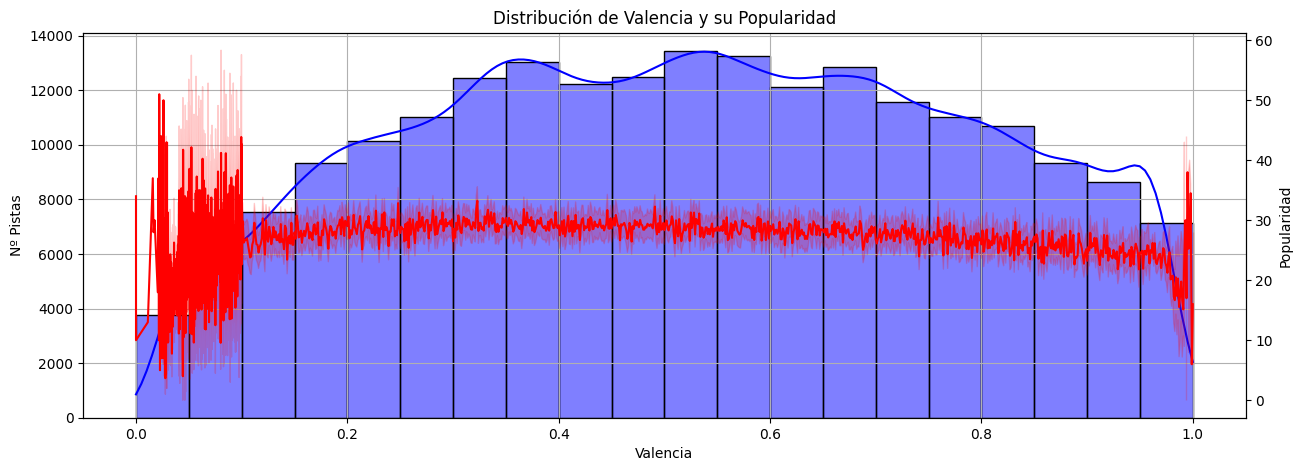

In [82]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot histogram of acousticness
sns.histplot(data=eda, x='valence', kde=True, color='blue', bins=20, ax=ax1)
ax1.set_xlabel('Valencia')
ax1.set_ylabel('Nº Pistas')
ax1.grid(True)

# Create second y-axis for popularity
ax2 = ax1.twinx()
sns.lineplot(data=eda, x='valence', y='popularity', ax=ax2, color='r')
ax2.set_ylabel('Popularidad')

plt.title('Distribución de Valencia y su Popularidad')
plt.show()

### Matriz de correlación

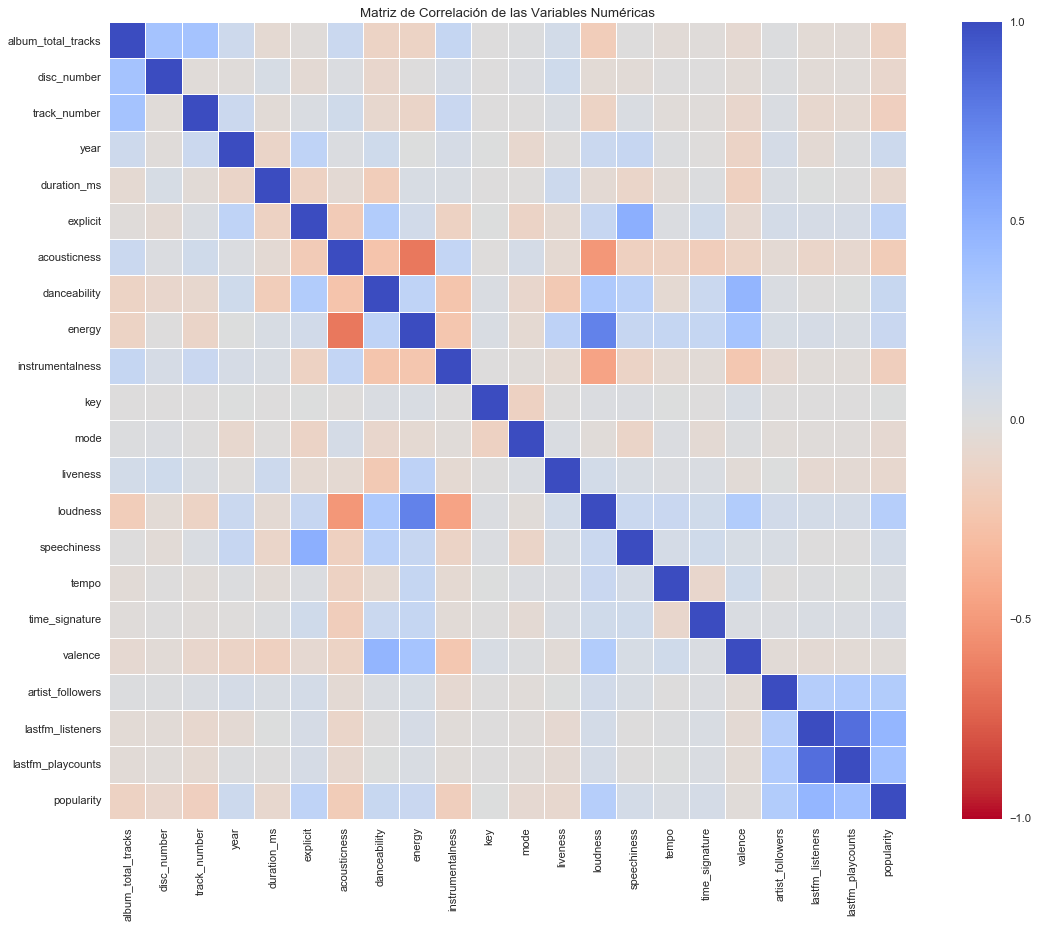

In [369]:
#remove id column and get corr
corr = eda.drop(['id', 'title', 'artist', 'artist_id', 'album', 'root_title', 'month', 'month_name', 'release_date', 'artist_genres', 'duration_min'], axis=1).corr()

# Crear una máscara para la matriz triangular superior
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 12))

# Crear el mapa de calor de la matriz de correlación
sns.heatmap(corr, cmap='coolwarm_r', annot=False, vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.title('Matriz de Correlación de las Variables Numéricas')
plt.show()

## Extracción de Características a partir del análisis

In [251]:
feng = df.copy()

### DESCARTADOS

#### Categorizar instrumentalness

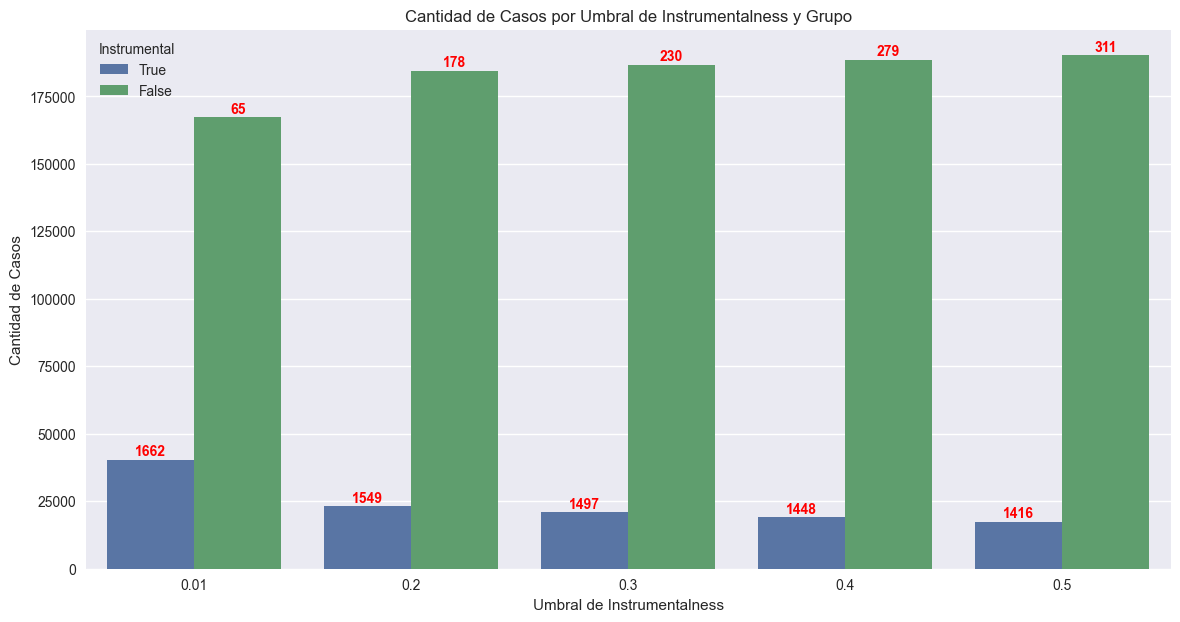

Threshold Instrumental   Count  Instrumental_Count
0       0.01         True   40414                1662
1       0.20         True   23118                1549
2       0.30         True   20863                1497
3       0.40         True   19021                1448
4       0.50         True   17455                1416
5       0.01        False  167213                  65
6       0.20        False  184509                 178
7       0.30        False  186764                 230
8       0.40        False  188606                 279
9       0.50        False  190172                 311

In [45]:

# Crear una lista de umbrales
thresholds = [0.01, 0.2, 0.3, 0.4, 0.5]

# Listas para almacenar los resultados
threshold_list = []
group_list = []
count_list = []
instrumental_count_list = []

# Iterar sobre los umbrales y calcular la cantidad de casos
for threshold in thresholds:
    # Categorizar la variable instrumentalness
    feng[f'Instrumental_{threshold}'] = feng['instrumentalness'] > threshold

    # Contar la cantidad de casos
    count_true = feng[feng[f'Instrumental_{threshold}'] == True].shape[0]
    count_false = feng[feng[f'Instrumental_{threshold}'] == False].shape[0]

    # Contar los títulos que contienen "Instrumental"
    title_instrumental_true = feng[(feng[f'Instrumental_{threshold}'] == True) & (feng['title'].str.contains('Instrumental', case=False, na=False))].shape[0]
    title_instrumental_false = feng[(feng[f'Instrumental_{threshold}'] == False) & (feng['title'].str.contains('Instrumental', case=False, na=False))].shape[0]

    # Agregar los resultados a las listas
    threshold_list.extend([threshold, threshold])
    group_list.extend(['True', 'False'])
    count_list.extend([count_true, count_false])
    instrumental_count_list.extend([title_instrumental_true, title_instrumental_false])

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'Threshold': threshold_list,
    'Instrumental': group_list,
    'Count': count_list,
    'Instrumental_Count': instrumental_count_list
})

# reorder results_df to the following order of indexes: 0, 2, 4, 6, 8, 1, 3, 5, 7, 9
results_df = results_df.reindex([0, 2, 4, 6, 8, 1, 3, 5, 7, 9])
results_df.reset_index(drop=True, inplace=True)
# Configurar el tamaño de la figura
plt.figure(figsize=(14, 7))

# Crear el gráfico de barras
sns.barplot(data=results_df, x='Threshold', y='Count', hue='Instrumental')



# Agregar etiquetas a cada barra
for i in range(len(results_df)):
    bar = plt.gca().patches[i]
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 500, results_df['Instrumental_Count'][i], ha='center', va='bottom', color='red', weight='bold')

plt.title('Cantidad de Casos por Umbral de Instrumentalness y Grupo')
plt.xlabel('Umbral de Instrumentalness')
plt.ylabel('Cantidad de Casos')
plt.legend(title='Instrumental')
plt.show()

results_df

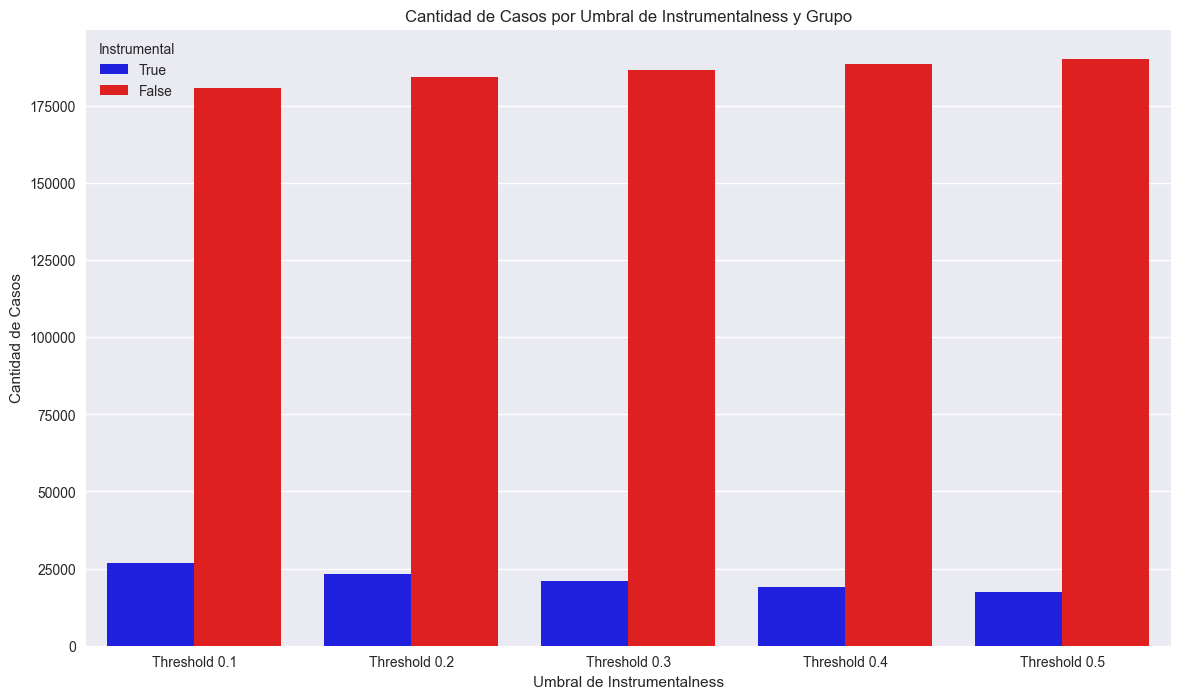

In [46]:
# Crear una lista de umbrales
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

# Listas para almacenar los resultados
threshold_list = []
group_list = []
count_list = []

# Iterar sobre los umbrales y calcular la cantidad de casos
for threshold in thresholds:
    # Categorizar la variable instrumentalness
    feng[f'Instrumental_{threshold}'] = feng['instrumentalness'] > threshold

    # Contar la cantidad de casos
    count_true = feng[feng[f'Instrumental_{threshold}'] == True].shape[0]
    count_false = feng[feng[f'Instrumental_{threshold}'] == False].shape[0]

    # Agregar los resultados a las listas
    threshold_list.extend([f'Threshold {threshold}'] * 2)
    group_list.extend(['True', 'False'])
    count_list.extend([count_true, count_false])

# Crear un DataFrame con los resultados
df_results = pd.DataFrame({
    'Threshold': threshold_list,
    'Group': group_list,
    'Count': count_list
})

# Configurar el tamaño de la figura
plt.figure(figsize=(14, 8))

# Crear el gráfico de barras
sns.barplot(x='Threshold', y='Count', hue='Group', data=df_results, palette=['blue', 'red'])

# Agregar etiquetas y título
plt.xlabel('Umbral de Instrumentalness')
plt.ylabel('Cantidad de Casos')
plt.title('Cantidad de Casos por Umbral de Instrumentalness y Grupo')
plt.legend(title='Instrumental')

# Mostrar el gráfico
plt.show()


#### Categorizar liveness

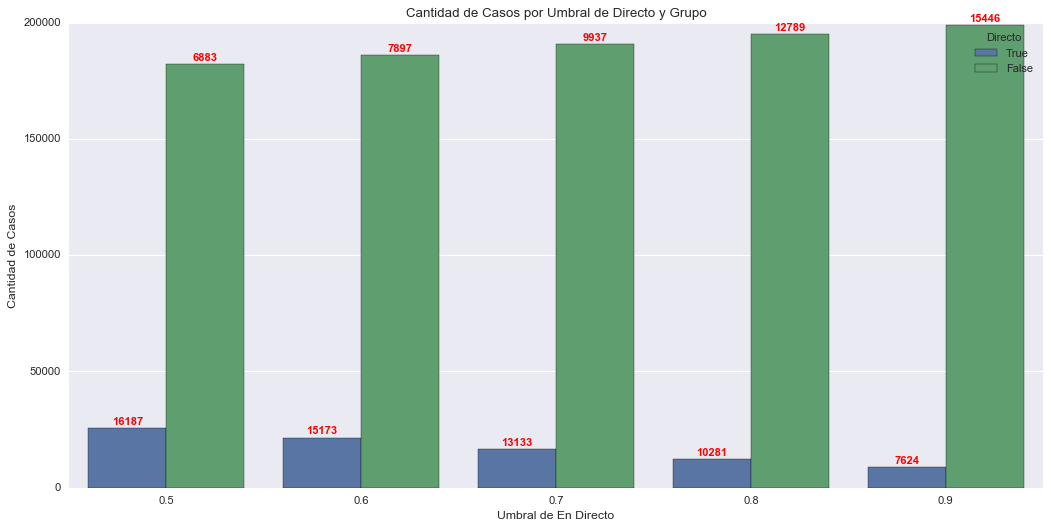

Threshold Directo   Count  Directo_Count
0        0.5    True   25464          16187
1        0.6    True   21556          15173
2        0.7    True   16723          13133
3        0.8    True   12381          10281
4        0.9    True    8705           7624
5        0.5   False  182163           6883
6        0.6   False  186071           7897
7        0.7   False  190904           9937
8        0.8   False  195246          12789
9        0.9   False  198922          15446

In [408]:

# Crear una lista de umbrales
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

# Listas para almacenar los resultados
threshold_list = []
group_list = []
count_list = []
liveness_count_list = []

# Iterar sobre los umbrales y calcular la cantidad de casos
for threshold in thresholds:
    # Categorizar la variable instrumentalness
    feng[f'Directo_{threshold}'] = feng['liveness'] > threshold

    # Contar la cantidad de casos
    count_true = feng[feng[f'Directo_{threshold}'] == True].shape[0]
    count_false = feng[feng[f'Directo_{threshold}'] == False].shape[0]

    # Contar los títulos que contienen "Instrumental"
    title_liveness_true = feng[(feng[f'Directo_{threshold}'] == True) & (feng['root_title'].str.endswith('- Live'))].shape[0]
    title_liveness_false = feng[(feng[f'Directo_{threshold}'] == False) & (feng['root_title'].str.endswith('- Live'))].shape[0]

    # Agregar los resultados a las listas
    threshold_list.extend([threshold, threshold])
    group_list.extend(['True', 'False'])
    count_list.extend([count_true, count_false])
    liveness_count_list.extend([title_liveness_true, title_liveness_false])

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'Threshold': threshold_list,
    'Directo': group_list,
    'Count': count_list,
    'Directo_Count': liveness_count_list
})

# reorder results_df to the following order of indexes: 0, 2, 4, 6, 8, 1, 3, 5, 7, 9
results_df = results_df.reindex([0, 2, 4, 6, 8, 1, 3, 5, 7, 9])
results_df.reset_index(drop=True, inplace=True)
# Configurar el tamaño de la figura
plt.figure(figsize=(14, 7))

# Crear el gráfico de barras
sns.barplot(data=results_df, x='Threshold', y='Count', hue='Directo')



# Agregar etiquetas a cada barra
for i in range(len(results_df)):
    bar = plt.gca().patches[i]
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 500, results_df['Directo_Count'][i], ha='center', va='bottom', color='red', weight='bold')

plt.title('Cantidad de Casos por Umbral de Directo y Grupo')
plt.xlabel('Umbral de En Directo')
plt.ylabel('Cantidad de Casos')
plt.legend(title='Directo')
plt.show()

results_df

#### Posicion normalizada de la canción

In [409]:
#  Calculamos la posición normalizada
feng['posicion'] = (feng['track_number'] + (feng['disc_number'] - 1) * feng['album_total_tracks']) / (feng['album_total_tracks'] * feng['disc_number'])

# Mostrar las primeras filas con mas de un disco
print(feng[feng['disc_number'] > 1].head())

                           id                          title           artist  \
11286  54ipXppHLA8U4yqpOFTUhr                          Bones  Imagine Dragons   
17818  2EBCVPNAG46nbgs6jXPGvv                      Starships      Nicki Minaj   
93963  1QFh8OH1e78dGd3VyJZCAC                 Boys Don't Cry         The Cure   
67135  4VQNCzfZ3MdHEwwErNXpBo  All Eyez On Me (ft. Big Syke)             2Pac   
92043  5Z8Dj3LtbyCMiwE86rhg2f     Marea (we’ve lost dancing)     Fred again..   

                    artist_id  \
11286  53XhwfbYqKCa1cC15pYq2q   
17818  0hCNtLu0JehylgoiP8L4Gh   
93963  7bu3H8JO7d0UbMoVzbo70s   
67135  1ZwdS5xdxEREPySFridCfh   
92043  4oLeXFyACqeem2VImYeBFe   

                                                   album      root_title  \
11286                               Mercury - Acts 1 & 2           Bones   
17818  Pink Friday: Roman Reloaded The Re-Up (Explici...       Starships   
93963                               Three Imaginary Boys  Boys Don't Cry   
67135     

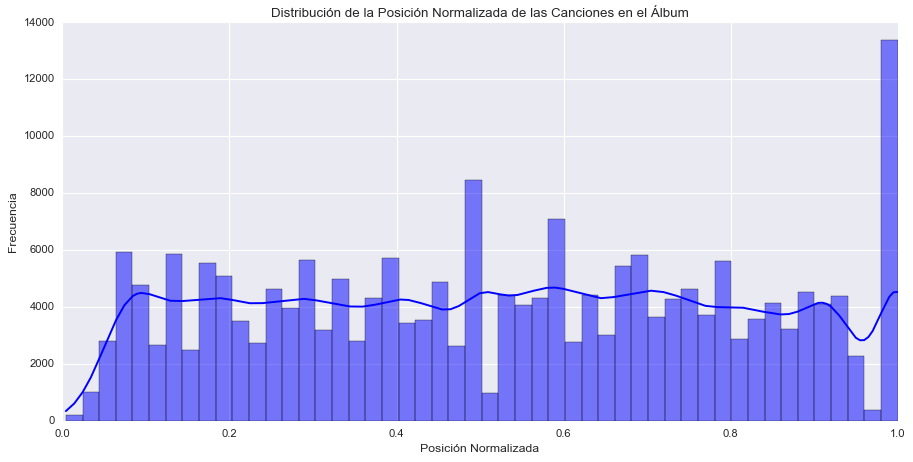

In [410]:
# Verificar la distribución de la posición normalizada
plt.figure(figsize=(12, 6))
sns.histplot(feng['posicion'], kde=True, bins=50, color='blue')
plt.title('Distribución de la Posición Normalizada de las Canciones en el Álbum')
plt.xlabel('Posición Normalizada')
plt.ylabel('Frecuencia')
plt.show()

# # Verificar la relación entre la posición normalizada y la popularidad
# plt.figure(figsize=(12, 6))
# sns.scatterplot(data=feng, x='posicion', y='popularity', alpha=0.5)
# plt.title('Relación entre Posición Normalizada y Popularidad')
# plt.xlabel('Posición Normalizada')
# plt.ylabel('Popularidad')
# plt.show()


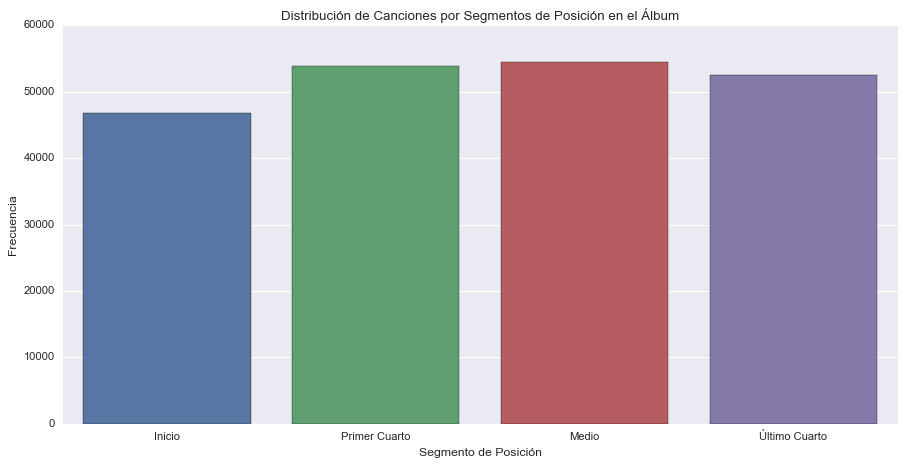

In [411]:
# Definir segmentos para la posición normalizada
bins = [0, 0.25, 0.5, 0.75, 1]
labels = ['Inicio', 'Primer Cuarto', 'Medio', 'Último Cuarto']

# Crear una nueva columna categorizada
feng['posicion_segmentada'] = pd.cut(feng['posicion'], bins=bins, labels=labels, include_lowest=True)

# Verificar la distribución
plt.figure(figsize=(12, 6))
sns.countplot(data=feng, x='posicion_segmentada')
plt.title('Distribución de Canciones por Segmentos de Posición en el Álbum')
plt.xlabel('Segmento de Posición')
plt.ylabel('Frecuencia')
plt.show()


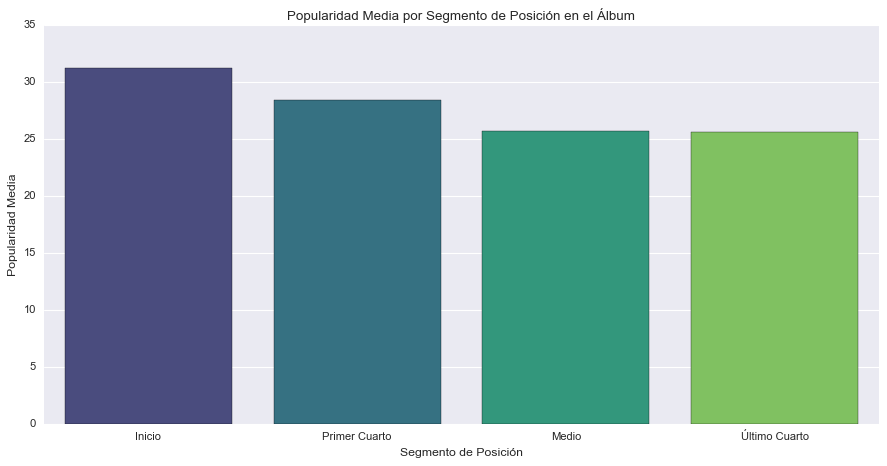

In [412]:
# Calcular la popularidad media por segmento de posición
popularity_by_segment = feng.groupby('posicion_segmentada')['popularity'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=popularity_by_segment, x='posicion_segmentada', y='popularity', palette='viridis')
plt.title('Popularidad Media por Segmento de Posición en el Álbum')
plt.xlabel('Segmento de Posición')
plt.ylabel('Popularidad Media')
plt.show()


#### Posicion absoluta de la canción

In [413]:
feng2 = feng.copy()
# Paso 1: Calcular el número total de pistas por disco de cada álbum
track_counts = feng2.groupby(['artist', 'album', 'disc_number']).size().reset_index(name='total_tracks')

# Paso 2: Calcular la posición absoluta considerando el número de pistas en los discos anteriores
def calculate_absolute_position(group):
    group = group.sort_values(by=['disc_number', 'track_number'])
    group['disc_cumulative_tracks'] = group['total_tracks'].cumsum().shift(fill_value=0)
    group['absolute_position'] = group['track_number'] + group['disc_cumulative_tracks']
    return group

feng2 = feng2.merge(track_counts, on=['artist', 'album', 'disc_number'])
feng2 = feng2.groupby(['artist', 'album']).apply(calculate_absolute_position)

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000029B184A39C0>
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 


In [ ]:
feng2 = feng.copy()

track_counts = feng2.groupby(['artist', 'album', 'disc_number']).size().reset_index(name='total_tracks')

# Paso 2: Calcular la posición absoluta considerando el número de pistas en los discos anteriores
def calculate_absolute_position(group):
    group = group.sort_values(by=['disc_number', 'track_number'])
    group['disc_cumulative_tracks'] = group['total_tracks'].cumsum().shift(fill_value=0)
    group['absolute_position'] = group['track_number'] + group['disc_cumulative_tracks']
    return group

feng2 = feng2.merge(track_counts, on=['artist', 'album', 'disc_number'])
feng2['total_tracks_before'] = feng2.groupby(['artist', 'album'])['total_tracks'].cumsum() - feng2['total_tracks']
feng2['absolute_position'] = feng2['track_number'] + feng2['total_tracks_before']

# Visualizar el resultado
print(feng2[['artist', 'album', 'disc_number', 'track_number', 'absolute_position']])

               artist                               album  disc_number  \
0       Billie Eilish                HIT ME HARD AND SOFT            1   
1       Billie Eilish                HIT ME HARD AND SOFT            1   
2       Billie Eilish                HIT ME HARD AND SOFT            1   
3       Billie Eilish                HIT ME HARD AND SOFT            1   
4       Billie Eilish                HIT ME HARD AND SOFT            1   
...               ...                                 ...          ...   
207622      S. Janaki    Dharmada Degula Sri Dhramasthala            1   
207623      S. Janaki    Dharmada Degula Sri Dhramasthala            1   
207624      S. Janaki    Dharmada Degula Sri Dhramasthala            1   
207625    Swarnalatha  Nedumbalathu Arasi Eswara Kamatchi            1   
207626    Swarnalatha  Nedumbalathu Arasi Eswara Kamatchi            1   

        track_number  absolute_position  
0                  4                  4  
1                  2       

In [ ]:
feng2 = eda.copy()
# Paso 1: Calcular el número total de pistas por disco de cada álbum
track_counts = feng2.groupby(['artist', 'album', 'disc_number'])['track_number'].max().reset_index(name='total_tracks')

# Paso 2: Calcular la posición absoluta considerando el número de pistas en los discos anteriores
def calculate_absolute_position(df):
    df = df.sort_values(by=['disc_number', 'track_number'])
    df['cumulative_tracks'] = df['total_tracks'].shift().fillna(0).cumsum()
    df['absolute_position'] = df['track_number'] + df['cumulative_tracks']
    return df

# Merge el track_counts para usarlo en el cálculo
feng3 = pd.merge(feng2, track_counts, on=['artist', 'album', 'disc_number'])

# Agrupar por artista y álbum para aplicar la función
feng3 = feng3.groupby(['artist', 'album']).apply(calculate_absolute_position).reset_index(drop=True)

# Visualizar el resultado
print(feng3[['artist', 'album', 'disc_number', 'track_number', 'absolute_position']])

       artist           album  disc_number  track_number  absolute_position
0        $NOT     - TRAGEDY +            1             2                2.0
1        $NOT     - TRAGEDY +            1             3               15.0
2        $NOT     - TRAGEDY +            1             4               28.0
3        $NOT     - TRAGEDY +            1             5               41.0
4        $NOT     - TRAGEDY +            1             6               54.0
...       ...             ...          ...           ...                ...
207622   ヨルシカ  負け犬にアンコールはいらない            1             4               22.0
207623   ヨルシカ  負け犬にアンコールはいらない            1             6               33.0
207624   ヨルシカ  負け犬にアンコールはいらない            1             7               43.0
207625   ヨルシカ  負け犬にアンコールはいらない            1             8               53.0
207626   ヨルシカ  負け犬にアンコールはいらない            1             9               63.0

[207627 rows x 5 columns]


In [ ]:
# Visualizar el resultado con disc_number > 1
# feng3 = feng3.droplevel(0)
feng3 = feng2.copy()
feng3[['id', 'title', 'artist', 'album', 'album_total_tracks', 'disc_number', 'total_tracks', 'disc_cumulative_tracks', 'track_number', 'absolute_position']]

id  \
artist album                                          
$NOT   - TRAGEDY +    34323  4VzhdfRpM2sQjhzwYWjd30   
                      34324  0XVs3503u3CZ4k6xobVEHP   
                      34320  3oGbHF3Kdwf3AsRCbBjUxu   
                      34322  6gkm8eZDBIEu7VFEZbkcFx   
                      34327  4cLABSn9fZX6tWcGxFTxvo   
...                                             ...   
ヨルシカ   負け犬にアンコールはいらない 12444  153lRbNmhQZVi69kbhmjY8   
                      12447  7nj9JW6QQrholNi2R2lffN   
                      12443  3wJHCry960drNlAUGrJLmz   
                      12448  28QP3jpaBPGgKKH4x3y5Dg   
                      12449  2JpShP9hy9ZsuHTAG64EH2   

                                                             title artist  \
artist album                                                                
$NOT   - TRAGEDY +    34323                               PRESSURE   $NOT   
                      34324                           FALL IN LOVE   $NOT   
                      34320  Moon & Stars (feat. Maggie Lindemann)   $NOT   
                      34322                           ROADRUNNER +   $NOT   
                      34327                     WHAT'S THE PROBLEM   $NOT   
...                                                            ...    ...   
ヨルシカ   負け犬にアンコールはいらない 12444                                 ヒッチコック   ヨルシカ   
                      12447                                  準透明少年   ヨルシカ   
                      12443                                 ただ君に晴れ   ヨルシカ   
                      12448                                     冬眠   ヨルシカ   
                      12449                             夏、バス停、君を待つ   ヨルシカ   

                                      album  album_total_tracks  disc_number  \
artist album                                                                   
$NOT   - TRAGEDY +    34323     - TRAGEDY +                  12            1   
                      34324     - TRAGEDY +                  12            1   
                      34320     - TRAGEDY +                  12            1   
                      34322     - TRAGEDY +                  12            1   
                      34327     - TRAGEDY +                  12            1   
...                                     ...                 ...          ...   
ヨルシカ   負け犬にアンコールはいらない 12444  負け犬にアンコールはいらない                   9            1   
                      12447  負け犬にアンコールはいらない                   9            1   
                      12443  負け犬にアンコールはいらない                   9            1   
                      12448  負け犬にアンコールはいらない                   9            1   
                      12449  負け犬にアンコールはいらない                   9            1   

                             total_tracks  disc_cumulative_tracks  \
artist album                                                        
$NOT   - TRAGEDY +    34323            11                       0   
                      34324            11                      11   
                      34320            11                      22   
                      34322            11                      33   
                      34327            11                      44   
...                                   ...                     ...   
ヨルシカ   負け犬にアンコールはいらない 12444             7                      14   
                      12447             7                      21   
                      12443             7                      28   
                      12448             7                      35   
                      12449             7                      42   

                             track_number  absolute_position  
artist album                                                  
$NOT   - TRAGEDY +    34323             2                  2  
                      34324             3                 14  
                      34320             4                 26  
                      34322             5                 38  
              

In [ ]:
# remove instances with absolute_position > 500
feng2 = feng[feng['absolute_position'] <= 500]

In [ ]:
feng3 = feng2[['id', 'album_total_tracks', 'disc_number', 'track_number', 'total_tracks', 'absolute_position', 'year', 'duration_ms', 'explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'mode', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence', 'artist_genres', 'artist_followers', 'lastfm_listeners', 'lastfm_playcounts', 'popularity']]

profile = ProfileReport(feng3, title="Feature Engineering", explorative=True)
profile.to_file("reports/prueba_feng.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
feng.head()

title         artist  \
23376                          End of Beginning            Djo   
206                                Cruel Summer   Taylor Swift   
2419                                  Like That         Future   
30                Fortnight (feat. Post Malone)   Taylor Swift   
696    we can't be friends (wait for your love)  Ariana Grande   

                                           artist_genres  artist_followers  \
23376                  ['pov: indie', 'psychedelic pop']           1298994   
206                                              ['pop']         109436455   
2419   ['atl hip hop', 'hip hop', 'rap', 'southern hi...          16864828   
30                                               ['pop']         109436455   
696                                              ['pop']          96092902   

       lastfm_listeners  lastfm_playcounts                          album  \
23376          883827.0         11285515.0                         DECIDE   
206           1203871.0         35424173.0                          Lover   
2419           600509.0          6557336.0             WE DON'T TRUST YOU   
30             597171.0          6494174.0  THE TORTURED POETS DEPARTMENT   
696            630721.0         11328866.0               eternal sunshine   

       track_number  album_total_tracks  disc_number release_date  \
23376             6                  13            1   2022-09-16   
206               2                  18            1   2019-08-23   
2419              6                  17            1   2024-03-22   
30                1                  16            1   2024-04-18   
696              10                  13            1   2024-03-08   

       duration_ms  explicit  acousticness  danceability  energy  \
23376       159245         0       0.03510         0.689   0.454   
206         178426         0       0.11700         0.552   0.702   
2419        267706         1       0.00709         0.814   0.676   
30          228965         0       0.50200         0.504   0.386   
696         228639         0       0.06150         0.645   0.646   

       instrumentalness  liveness  loudness  speechiness  valence  key  \
23376          0.002590    0.0707    -7.643       0.0584    0.912    2   
206            0.000021    0.1050    -5.707       0.1570    0.564    9   
2419           0.000013    0.1190    -4.670       0.2310    0.312   11   
30             0.000015    0.0961   -10.976       0.0308    0.281   11   
696            0.000030    0.0740    -8.334       0.0427    0.295    5   

      key_name  mode mode_name    tempo  time_signature  popularity  \
23376       Re     1     Mayor  159.982               4          98   
206         La     1     Mayor  169.994               4          95   
2419        Si     0     menor  162.012               4          95   
30          Si     1     Mayor  192.004               4          95   
696         Fa     1     Mayor  115.842               4          94   

       release_date_year tonalidad  key_mode main_genre  pop_or_rap  \
23376               2022      Re M         3      Indie           0   
206                 2019      La M        10        Pop           1   
2419                2024      Si m       -12    Hip Hop           1   
30                  2024      Si M        12        Pop           1   
696                 2024      Fa M         6        Pop           1   

       rock_or_metal  latin  months_elapsed  duration_s  
23376              0      0       20.400000     159.245  
206                0      0       57.733333     178.426  
2419               0      0        1.966667     267.706  
30                 0      0        1.066667     228.965  
696                0      0        2.433333     228.639

### Duración en segundos en vez de milisegundos

In [290]:
# convert song duration units from ms to s
feng['duration_s'] = feng['duration_ms'].apply(lambda x: x/1000)

### Tonalidad (`key` * `mode`)

La variable `key` contiene la nota que predomina en la canción (en la mayoría de los casos suele ser la nota por la que empieza).

Si agregamos la variable `mode`, que nos dice si está en una escala Mayor o menor ("alegre" o "triste"), obtendremos la **tonalidad** de la canción.

In [272]:
tonalidad_order = ['Do m', 'Do# m', 'Re m', 'Mib m', 'Mi m', 'Fa m', 'Fa# m', 'Sol m', 'Sol# m', 'La m', 'Sib m', 'Si m', 'Do M', 'Do# M', 'Re M', 'Mib M', 'Mi M', 'Fa M', 'Fa# M', 'Sol M', 'Sol# M', 'La M', 'Sib M', 'Si M']
key_dict = {0: 'Do', 1: 'Do#', 2: 'Re', 3: 'Mib', 4: 'Mi', 5: 'Fa', 6: 'Fa#', 7: 'Sol', 8: 'Sol#', 9: 'La', 10: 'Sib', 11: 'Si'}
mode_dict = {0: 'm', 1: 'M'}

key_name = feng['key'].map(key_dict)
mode_name = feng['mode'].map(mode_dict)
feng['tonalidad'] = key_name + ' ' + mode_name

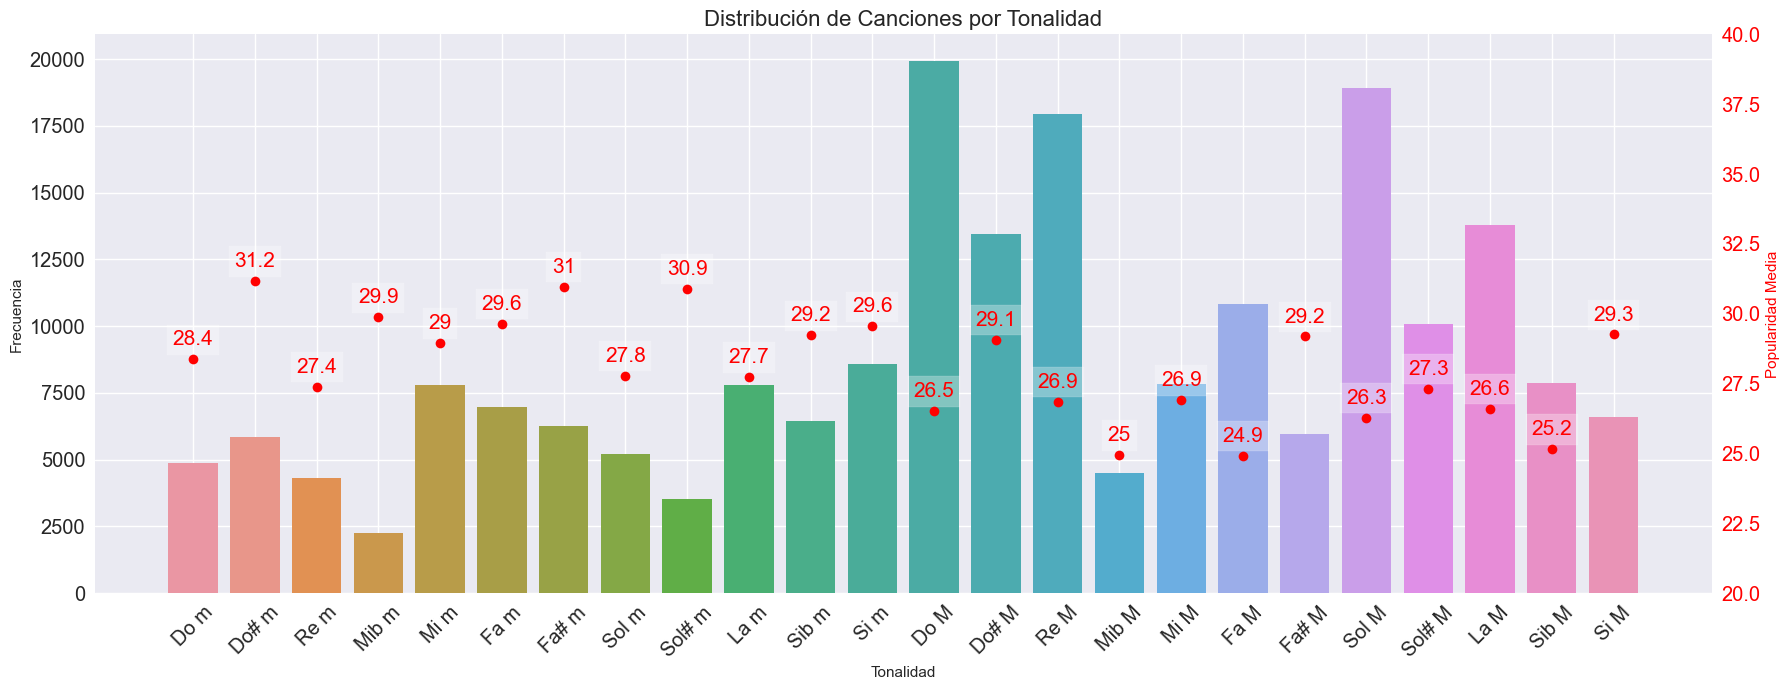

In [273]:
feng = feng.sort_values(by=['mode', 'key'])

# Antes de crear los gráficos, ajusta el tamaño de fuente global para los ticks
plt.rc('xtick', labelsize='x-large')  # Aumenta el tamaño de fuente de los xticks
plt.rc('ytick', labelsize='x-large')  # Aumenta el tamaño de fuente de los yticks

# Calcular la popularidad media por 'key_name' y 'mode_name'
avg_popularity_tonalidad = feng.groupby('tonalidad')['popularity'].mean()

# Plot tonalidad distribution with popularity
fig, ax1 = plt.subplots(figsize=(18, 7))

# Tonalidad
sns.countplot(data=feng, x='tonalidad', ax=ax1, zorder=3)
ax1.set_title('Distribución de Canciones por Tonalidad', fontsize=16)
ax1.set_xlabel('Tonalidad')
ax1.set_ylabel('Frecuencia')
ax1.grid(True, which='both', zorder=0)  # Asegurar que la cuadrícula esté detrás de las barras
ax1.tick_params(axis='x', rotation=45)

# Crear un segundo eje Y para la popularidad media en el primer gráfico
ax2 = ax1.twinx()
ax2.set_ylabel('Popularidad Media', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(20, 40)  # Establecer el límite del eje Y entre 0 y 100
ax2.grid(False)  # Desactivar la cuadrícula del segundo eje Y para que no interfiera con el histograma

# Añadir popularidad media sobre el diagrama de tonalidad
avg_popularity_tonalidad = avg_popularity_tonalidad.reindex(custom_order)

for tonalidad, pop in avg_popularity_tonalidad.items():
    ax2.annotate(format_popularity(pop),
                 xy=(list(avg_popularity_tonalidad.index).index(tonalidad), pop),
                 xytext=(0, 10),
                 textcoords='offset points',
                 fontsize=15,
                 ha='center',
                 backgroundcolor='#ffffff50',
                 color='red')
    ax2.plot(list(avg_popularity_tonalidad.index).index(tonalidad), pop, 'ro', zorder=4)  # Asegurar que los puntos estén encima de las barras

plt.tight_layout()
plt.show()


### Agrupar `artist_genres`

In [274]:
import ast
from collections import Counter

# Assuming df is your DataFrame and it has been properly defined earlier in your code
genres_df = feng.drop_duplicates('artist', keep='first')

all_subgenres = []
for list_genres_str in genres_df['artist_genres']:
    list_genres = ast.literal_eval(list_genres_str)  # Convert string representation of list to actual list
    all_subgenres.extend(list_genres)
    
count_subgenres = Counter(all_subgenres)
print(f'Hay {len(count_subgenres)} subgéneros únicos en el dataset.')

Hay 969 subgéneros únicos en el dataset.


In [280]:
all_subgenres[:10]

['garage rock',
 'modern rock',
 'permanent wave',
 'rock',
 'sheffield indie',
 'canadian contemporary r&b',
 'canadian pop',
 'pop',
 'pop',
 'permanent wave']

In [281]:
# Define a list of main genres
main_genres = ['Pop', 'Rock', 'Hip Hop', 'Indie', 'Country', 'Metal', 'Classical', 'Jazz', 'R&B', 'Reggae', 'Latin', 'Electronic', 'OST']

# Define a dictionary of main genres and associated subgenres
genres_dict = {
    'Pop': ['pop rock', 'commercial', 'synthpop', 'contemporary', 'modern', 'pop'],
    'Rock': ['hard rock', 'alternative rock', 'punk rock', 'road', 'garage rock'],
    'Hip Hop': ['rap', 'trap', 'boom bap', 'atl hip hop', 'bases', 'freestyle'],
    'Indie': ['indie rock', 'indie pop', 'indie folk'],
    'Country': ['country rock', 'country pop', 'bluegrass'],
    'Metal': ['heavy metal', 'death metal', 'black metal'],
    'OST' : ['bso', 'bollywood', 'filmi', 'hollywood', 'tollywood', 'soundtrack'],
    'Classical': ['baroque', 'romantic', 'modern classical', 'classic'],
    'Jazz': ['bebop', 'cool jazz', 'free jazz', 'lounge', 'swing', 'jazz'],
    'R&B': ['soul', 'funk', 'neo soul', 'delta blues', 'chicago blues', 'electric blues', 'funk', 'soul'],
    'Reggae': ['ska', 'dancehall', 'dub'],
    'Latin': ['salsa', 'reggaeton', 'latin pop', 'mexicana', 'mariachi', 'mexican', 'spanish', 'latino', 'banda', 'corrido', 'chihuahuense', 'colombian', 'sertanejo', 'arrocha'],
    'Electronic': ['house', 'techno', 'dubstep', 'dance'],
}

import ast

def map_genres(subgenres):
    # Parse the string into a list
    subgenres_list = ast.literal_eval(subgenres)
    for subgenre in subgenres_list:
        for main_genre, subgenres_in_dict in genres_dict.items():
            # Check if any subgenre in genres_dict is a substring of the subgenre
            if any(sub in subgenre for sub in subgenres_in_dict):
                return main_genre
            # Check if the main genre is in the subgenre
            elif main_genre.lower() in subgenre.lower():
                return main_genre
    return 'Otro'  # Return 'Otro' if no main genre is found

# Apply the function to the artist_genres column
feng['main_genre'] = feng['artist_genres'].apply(map_genres)

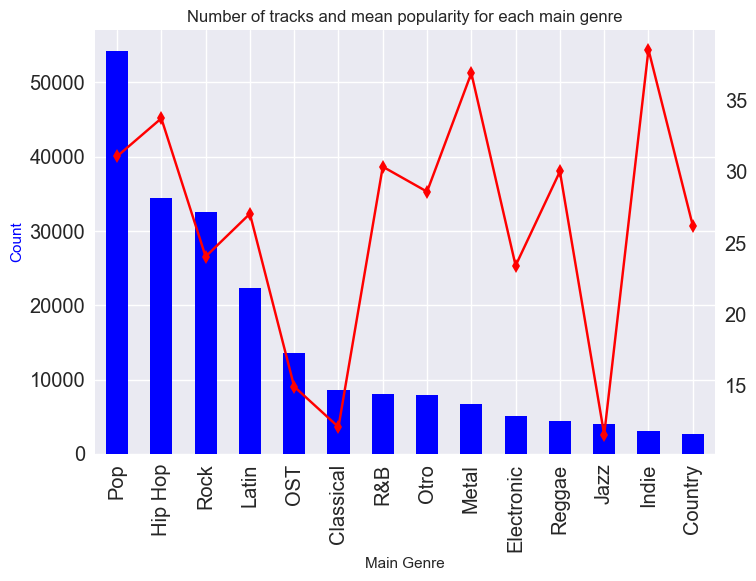

In [282]:
# Calculate the number of tracks and mean popularity for each genre
genre_data = feng.groupby('main_genre').agg({'main_genre': 'count', 'popularity': 'mean'}).rename(columns={'main_genre': 'count'})

genre_data = genre_data.sort_values('count', ascending=False)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the number of tracks for each genre
genre_data['count'].plot(kind='bar', color='blue', ax=ax1)

# Create a second y-axis for the mean popularity
ax2 = ax1.twinx()

# Plot the mean popularity for each genre
genre_data['popularity'].plot(kind='line', marker='d', secondary_y=True, color='red', ax=ax2)

# Set the labels and title
ax1.set_xlabel('Main Genre')
ax1.set_ylabel('Count', color='blue')
ax2.set_ylabel('Mean Popularity', color='red')
plt.title('Number of tracks and mean popularity for each main genre')

# Show the plot
plt.show()

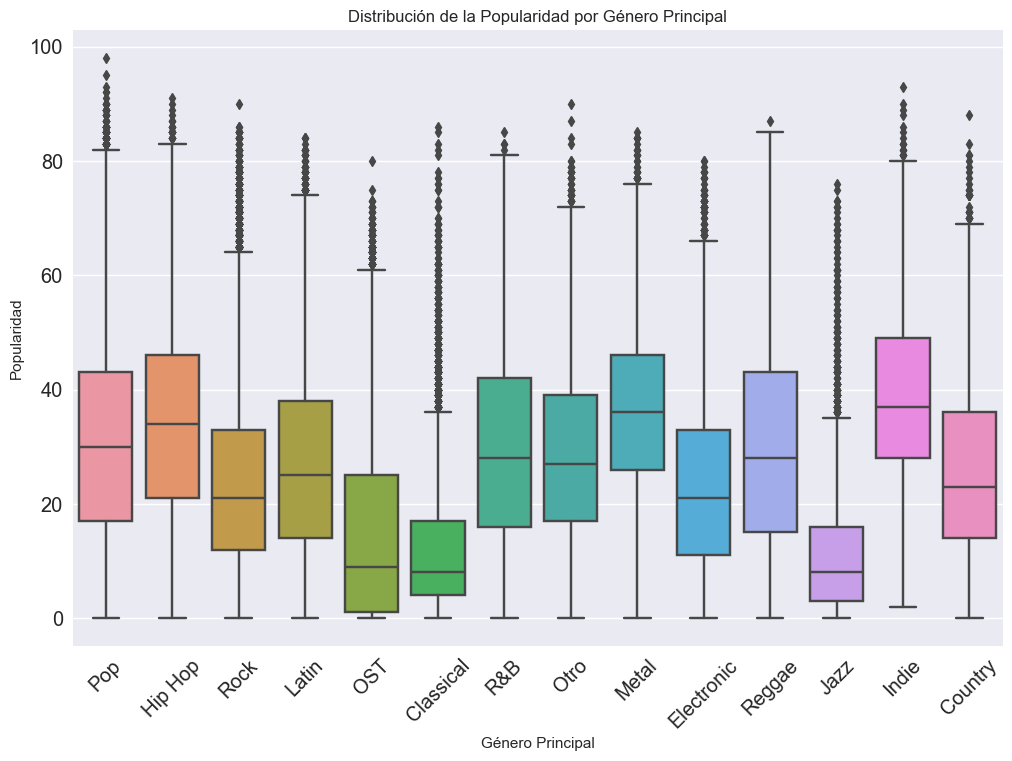

In [283]:
# Ordenar los géneros por frecuencia
genre_order = feng['main_genre'].value_counts().index

# Crear el boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='main_genre', y='popularity', data=feng, order=genre_order)
plt.title('Distribución de la Popularidad por Género Principal')
plt.xlabel('Género Principal')
plt.ylabel('Popularidad')
plt.xticks(rotation=45)
plt.show()

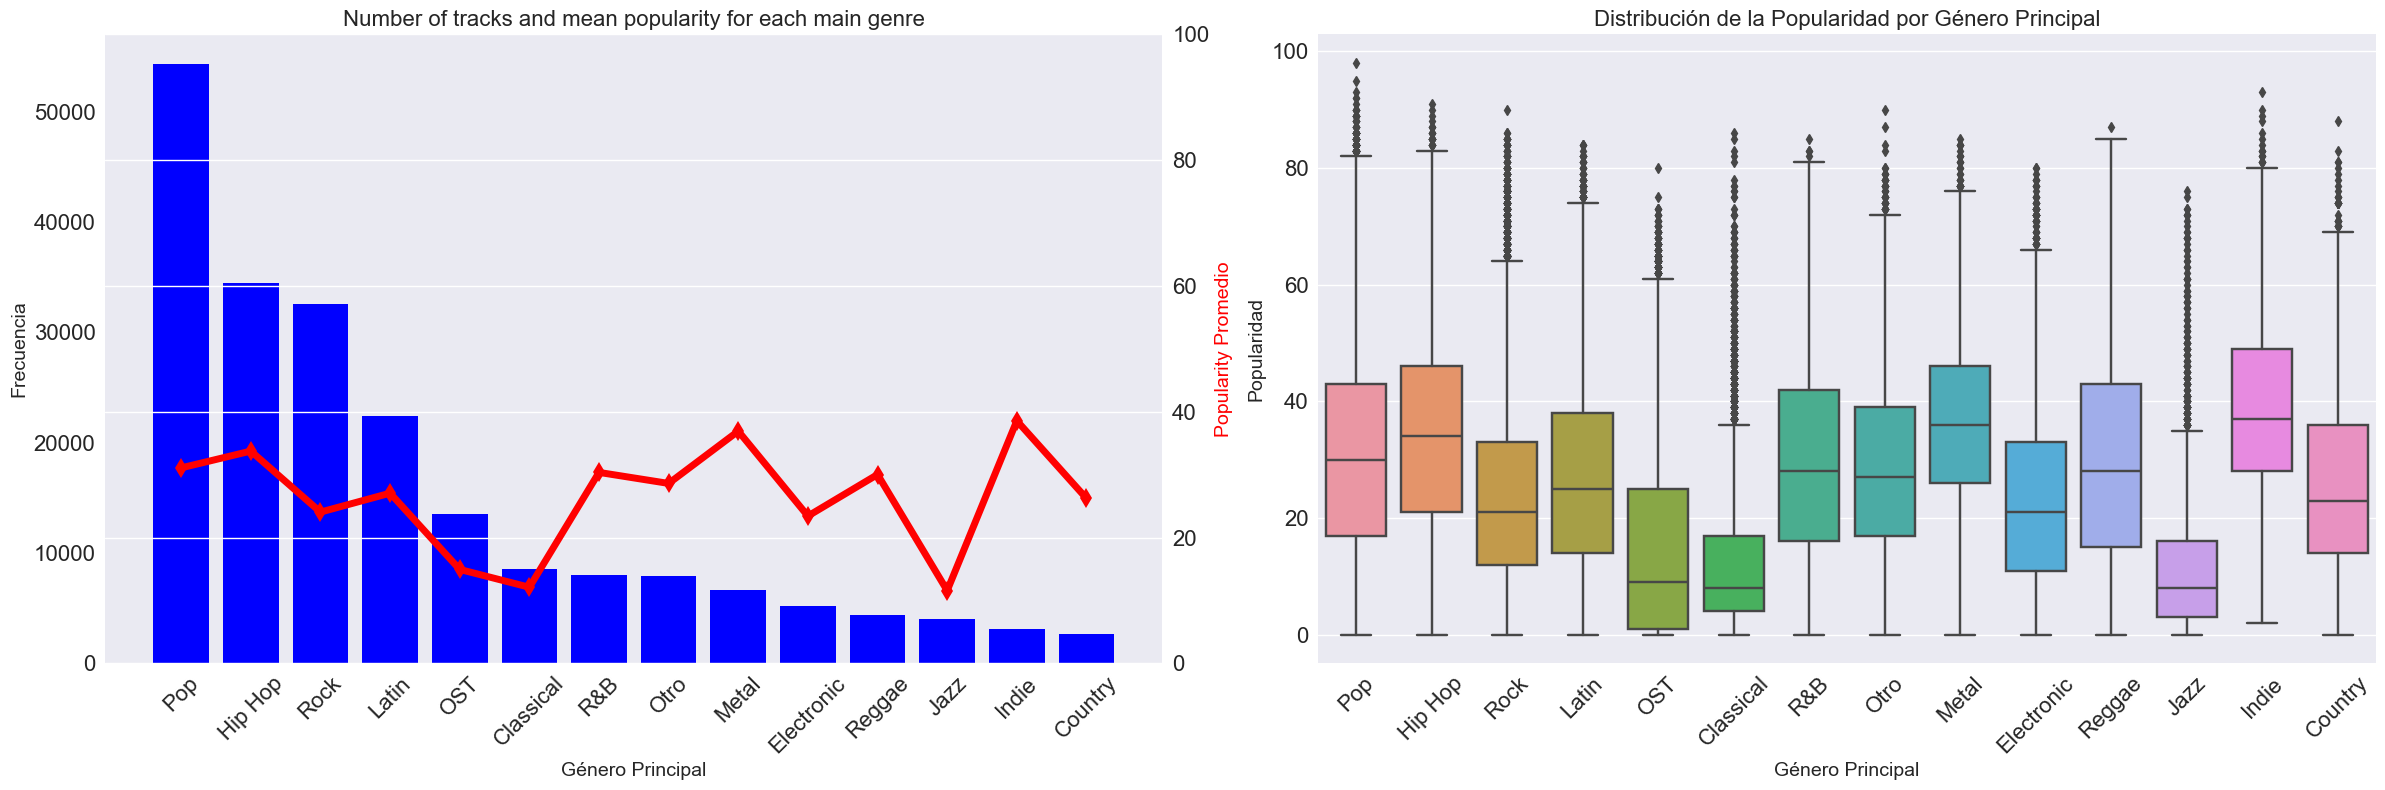

In [284]:
# Calcular el número de pistas y la popularidad media para cada género
genre_data = feng.groupby('main_genre').agg({'main_genre': 'count', 'popularity': 'mean'}).rename(columns={'main_genre': 'count'})
genre_data = genre_data.sort_values('count', ascending=False)

# Crear una figura y un conjunto de subgráficos
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(24, 8))

# Gráfico 1: Número de pistas y popularidad media para cada género
ax1.bar(genre_data.index, genre_data['count'], color='blue')
ax2 = ax1.twinx()
ax2.plot(genre_data.index, genre_data['popularity'], marker='d', color='red', linewidth=5, markersize=10)

# Configurar etiquetas y título para el gráfico 1
ax1.set_xlabel('Género Principal', fontsize=14)
ax1.set_ylabel('Frecuencia', fontsize=14)
ax2.set_ylabel('Popularity Promedio', color='red', fontsize=14)
ax2.set_ylim(0, 100)
ax1.set_title('Number of tracks and mean popularity for each main genre', fontsize=16)
ax1.tick_params(axis='x', rotation=45, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Eliminar las líneas de la cuadrícula del eje y de ax1
ax1.grid(False)

# Ordenar los géneros por frecuencia
genre_order = feng['main_genre'].value_counts().index

# Gráfico 2: Boxplot de la popularidad por género principal
sns.boxplot(x='main_genre', y='popularity', data=feng, order=genre_order, ax=ax3)
ax3.set_title('Distribución de la Popularidad por Género Principal', fontsize=16)
ax3.set_xlabel('Género Principal', fontsize=14)
ax3.set_ylabel('Popularidad', fontsize=14)
ax3.tick_params(axis='x', rotation=45, labelsize=16)
ax3.tick_params(axis='y', labelsize=16)

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar la figura
plt.show()

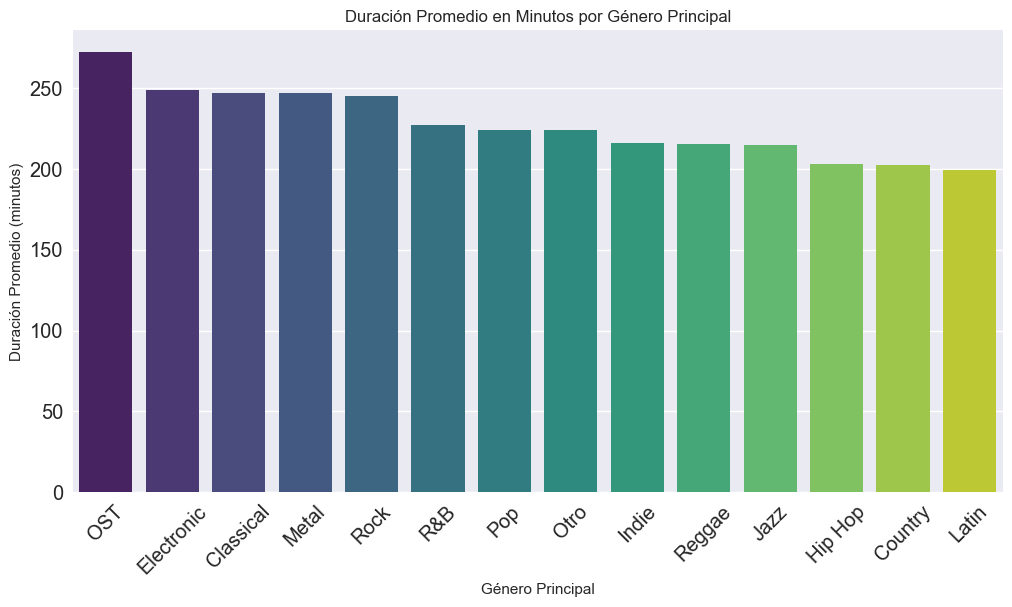

In [293]:
#DURACION MEDIA EN MINUTOS POR MAIN GENRE
# Calcular la duración media en minutos por género principal
duration_by_genre = feng.groupby('main_genre')['duration_s'].mean().sort_values(ascending=False)

# Crear un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=duration_by_genre.index, y=duration_by_genre, palette='viridis')
plt.title('Duración Promedio en Minutos por Género Principal')
plt.xlabel('Género Principal')
plt.ylabel('Duración Promedio (minutos)')
plt.xticks(rotation=45)
plt.show()


In [286]:
feng['rock'] = feng['main_genre'] == 'Rock'
feng['pop'] = feng['main_genre'] == 'Pop'
feng['hip_hop'] = feng['main_genre'] == 'Hip Hop'
feng['latin'] = feng['main_genre'] == 'Latin'

### Contador de meses desde el lanzamiento

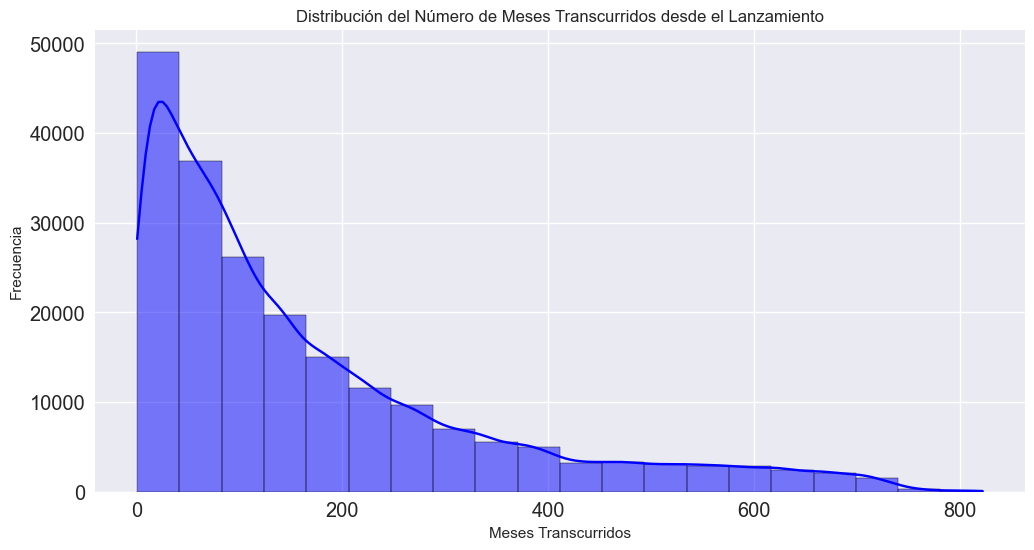

In [294]:
# Convert 'release_date' to datetime format
feng['release_date'] = pd.to_datetime(feng['release_date'])

# Calculate the number of months elapsed since the release of the songs
feng['months_elapsed'] = (dt.datetime.now() - feng['release_date']).dt.days / 30

# Plot the distribution of the number of months elapsed
plt.figure(figsize=(12, 6))
sns.histplot(feng['months_elapsed'], kde=True, color='blue', bins=20)
plt.title('Distribución del Número de Meses Transcurridos desde el Lanzamiento')
plt.xlabel('Meses Transcurridos')
plt.ylabel('Frecuencia')
plt.show()

### Ratio de reproducciones por oyentes

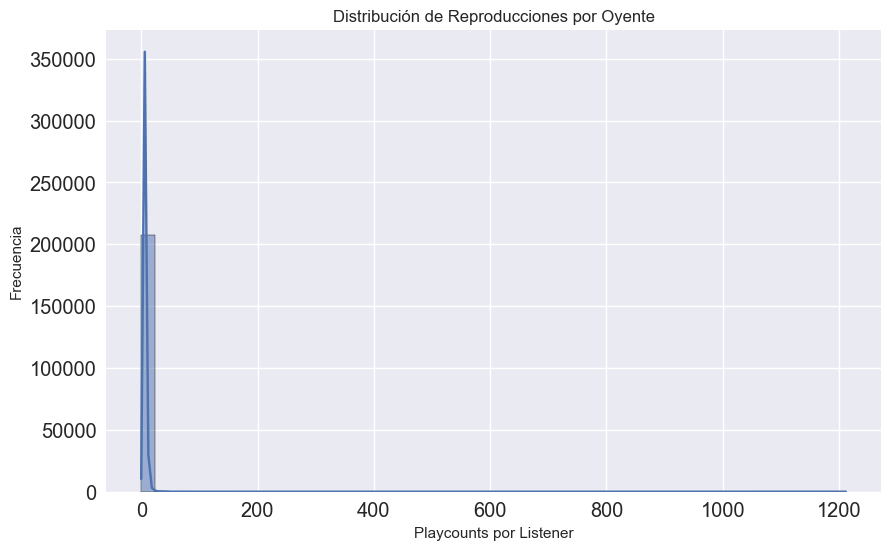

In [295]:
feng['lastfm_listeners'].fillna(0, inplace=True)
feng['lastfm_playcounts'].fillna(0, inplace=True)
feng['playcounts_per_listener'] = feng['lastfm_playcounts'] / feng['lastfm_listeners']
feng['playcounts_per_listener'].fillna(0, inplace=True)


# Visualización de la distribución de playcounts_per_listener
plt.figure(figsize=(10, 6))
sns.histplot(feng['playcounts_per_listener'], kde=True, bins=50)
plt.title('Distribución de Reproducciones por Oyente')
plt.xlabel('Playcounts por Listener')
plt.ylabel('Frecuencia')
plt.show()


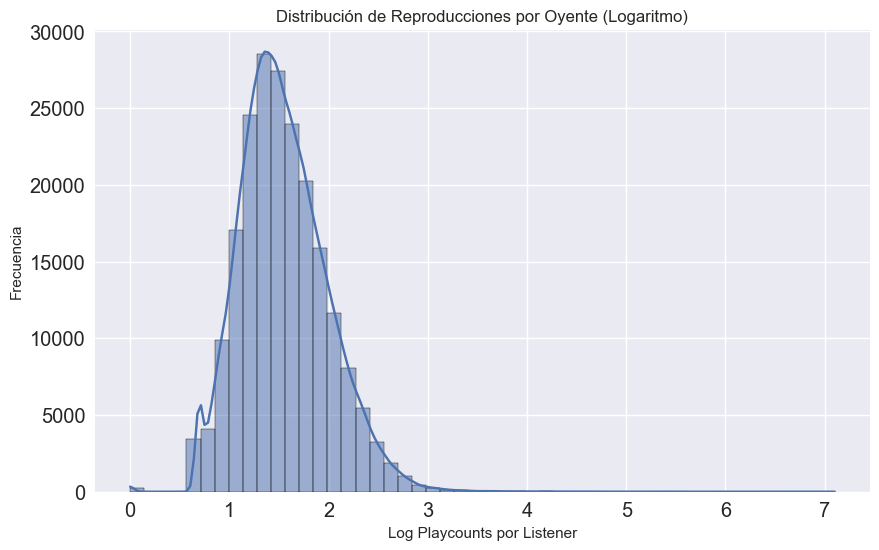

In [296]:
# playcounts per listeners a logaritmo
feng['log_playcounts_per_listener'] = np.log1p(feng['playcounts_per_listener'])

# Visualización de la distribución de log_playcounts_per_listener
plt.figure(figsize=(10, 6))
sns.histplot(feng['log_playcounts_per_listener'], kde=True, bins=50)
plt.title('Distribución de Reproducciones por Oyente (Logaritmo)')
plt.xlabel('Log Playcounts por Listener')
plt.ylabel('Frecuencia')
plt.show()

# Conclusiones

`energy` tiene una correlación muy alta con `acousticness`

`energy` tiene una correlación muy alta con `loudness`

Juntamos `key` y `mode` en una única variable  `key_mode` que represente la tonalidad de la canción (Do# Mayor, Sib menor, ...)

`popularity` está muy relacionada con las métricas de `last_fm` (oyentes y escuchas globales)


Podemos particionar el dataset en dos subsets para probar su eficacia a la hora de la predicción:
<ul>
    <li>Todas las canciones (~209.000 filas)</li>
    <li>Todas las canciones, sin features de lastfm ni seguidores del artista</li>
</ul>

## Dataset con variables nuevas

In [315]:
model_data = feng[['duration_s', 'months_elapsed', 'explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tonalidad','tempo', 'time_signature', 'pop', 'hip_hop', 'rock', 'latin', 
'artist_followers', 'log_playcounts_per_listener',
'popularity']]

report_data = feng[['duration_s', 'months_elapsed', 'explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'key', 'mode', 'tempo', 'time_signature', 'pop', 'hip_hop', 'rock', 'latin', 
'artist_followers', 'log_playcounts_per_listener',
'popularity']]

In [317]:
profile = ProfileReport(report_data, title="Model Data", explorative=True)
profile.to_file("reports/feng.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [318]:
model_data.to_csv("output/feng.csv")

# Dataset crudo para agregar las características del Feature Engineering en el pipeline de preprocesamiento

In [319]:
# id title artist artist_id album album_total_tracks disc_number track_number release_date duration_ms explicit acousticness danceability energy instrumentalness key mode liveness loudness speechiness tempo time_signature valence artist_genres artist_followers lastfm_listeners lastfm_playcounts popularity

dataset = eda[['id', 'title', 'artist', 'artist_id', 'album', 'album_total_tracks', 'disc_number', 'track_number', 'release_date', 'duration_ms', 'explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'mode', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence', 'artist_genres', 'artist_followers', 'lastfm_listeners', 'lastfm_playcounts', 'popularity']].copy()

dataset

id                                       title  \
8842    6dOtVTDdiauQNBQEDOtlAB                          BIRDS OF A FEATHER   
8840    629DixmZGHc7ILtEntuiWE                                       LUNCH   
21114   3qhlB30KknSejmIvZZLjOD                            End of Beginning   
8841    7BRD7x5pt8Lqa1eGYC4dzj                                     CHIHIRO   
206     1BxfuPKGuaTgP7aM0Bbdwr                                Cruel Summer   
...                        ...                                         ...   
151312  60qIC1qz7TCnVOf7mfQt7S         Kadal Pola (From "Thullura Vayasu")   
151328  55AU0kLEG8KIoMl2y3rD3P  En Parvaiyil Un Uruvam (From "Mathumathi")   
151693  4RedArUbz3JqZ9n7QAstm0                                 Aadhisakthi   
151694  0NCjZ6bjRhCArS4lDvjgas                                     Manamey   
213537  4Mg9wQIAkNZxPBn2fvngu5                                   Confucion   

                     artist               artist_id  \
8842          Billie Eilish  6qqNVTkY8uBg9cP3Jd7DAH   
8840          Billie Eilish  6qqNVTkY8uBg9cP3Jd7DAH   
21114                   Djo  5p9HO3XC5P3BLxJs5Mtrhm   
8841          Billie Eilish  6qqNVTkY8uBg9cP3Jd7DAH   
206            Taylor Swift  06HL4z0CvFAxyc27GXpf02   
...                     ...                     ...   
151312                Tippu  0PykiHCcDsMPRV7s67qZ1B   
151328                Tippu  0PykiHCcDsMPRV7s67qZ1B   
151693          Swarnalatha  7N0SBLJFpCyQSsv4MfRJ5d   
151694          Swarnalatha  7N0SBLJFpCyQSsv4MfRJ5d   
213537  El Chapo De Sinaloa  59Ih0XIAzMXq7Yf9ny3u5t   

                                     album  album_total_tracks  disc_number  \
8842                  HIT ME HARD AND SOFT                  10            1   
8840                  HIT ME HARD AND SOFT                  10            1   
21114                               DECIDE                  13            1   
8841                  HIT ME HARD AND SOFT                  10            1   
206                                  Lover                  18            1   
...                                    ...                 ...          ...   
151312                   Tippu Hits, Vol.2                  23            1   
151328        Tippu Hits - Playback Singer                  23            1   
151693  Nedumbalathu Arasi Eswara Kamatchi                   9            1   
151694  Nedumbalathu Arasi Eswara Kamatchi                   9            1   
213537                   20 Grandes Éxitos                  20            1   

        track_number release_date  duration_ms  explicit  acousticness  \
8842               4   2024-05-17       210373     False        0.2000   
8840               2   2024-05-17       179586     False        0.0452   
21114              6   2022-09-16       159245     False        0.0351   
8841               3   2024-05-17       303440     False        0.1440   
206                2   2019-08-23       178426     False        0.1170   
...              ...          ...          ...       ...           ...   
151312            15   2013-07-24       283235     False        0.2920   
151328            17   2013-06-18       261120     False        0.5070   
151693             1   2012-05-07       383284     False        0.7190   
151694             6   2012-05-07       287505     False        0.6730   
213537            13   2012-11-14       145496     False        0.5680   

        danceability  energy  instrumentalness  key  mode  liveness  loudness  \
8842           0.747   0.507          0.060800    2     1    0.1170   -10.171   
8840           0.893   0.400          0.082300   11     0    0.0632    -7.981   
21114          0.689   0.454          0.002590    2     1    0.0707    -7.643   
8841           0.700   0.425          0.879000    7     1    0.0830   -12.531   
206            0.552   0.702          0.000021    9     1    0.1050    -5.707   
...              ...     ...               ...  ...   ...       ...       ...   
151312         0.680   0.

In [320]:
dataset.to_csv("dataset.csv")